#### 해결해야할 문제1) 0시 이후 시간을 -1하다보니 -1된 상품이 해당 일의 가장 먼저 방송된 것으로 처리됨.
#### 예) 9월 15일 01:20에 방송된 쥐포는 9월 14일의 마지막 방송으로 처리되어야 하지만 9월 14일의 첫 방송으로 처리됨.

In [26]:
pip install xmltodict

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from datetime import datetime
import xmltodict
import requests
import re
# pd.set_option('display.max_rows', 100)
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.rcParams['font.family'] = 'Malgun Gothic'

In [77]:
# 나눔고딕코드 폰트 설치 (필요한사람만 돌리세요)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic')

In [371]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    sum_df = pd.read_csv('/content/drive/My Drive/빅데이터_콘테스트/sum_df.csv')
else:
    print('Not running on CoLab')
    sum_df = pd.read_csv('c:/bc/sum_df.csv')

Not running on CoLab


In [372]:
sum_df['HOUR'] = sum_df['HOUR'].replace(0,24).replace(1,25).replace(2,26)

In [373]:
sum_df['quarter'] = pd.to_datetime(sum_df.broadcast).dt.quarter

In [374]:
sum_df['timeslot'] = pd.cut(sum_df.HOUR, bins = [5,8,11,14,17,20,23,26], \
                             labels = [1,2,3,4,5,6,7])

In [148]:
seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
month_to_season = dict(zip(range(1,13), seasons))

In [149]:
sum_df['season'] = sum_df.MONTH.map(month_to_season)

### 공휴일 정보 가져오기

In [150]:
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

total = {}
for i in month:
    service_key = 'JJC5IlOjBjhMwMvARvd2a0D3jVjHuA3DDvF1NZ27DH4pbq5Y1bzUmA0zYt6BOvI562qNa8Z87PlDLZZjYHA3YA%3D%3D'
    service_key_decode = requests.utils.unquote(service_key)

    req_params = {'ServiceKey' : service_key_decode, 'solYear' : '2019', 'solMonth' : i}
    req_url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo'

    resp = requests.get(req_url, params =req_params)
    xml_data = resp.text
    dict_data = xmltodict.parse(xml_data)

    if dict_data ['response']['body']['items'] is not None:
        data = dict_data ['response']['body']['items']['item']

        total[i] =  data

month_1 = ['01', '03', '06', '08', '12']

공휴일 = []
for  mon in month:
    if mon in month_1 :
        date = total[mon]['locdate']
        holiday = total[mon]['isHoliday']
        공휴일.append(date)

month_2 = ['02', '05', '09', '10']
for mon in month:
    if mon in month_2 :
        len_mon = len(total[mon])
        for d in range(len_mon):
            date = total[mon][d]['locdate']
            holiday = total[mon][d]['isHoliday']
            공휴일.append(date)
            
공휴일 = pd.to_datetime(공휴일, format='%Y-%m-%d', errors='raise')

In [151]:
def holiday(date):  
    if date in 공휴일 :
        holi = 1
    else:
        holi = 0
    return holi

sum_df['공휴일'] = sum_df['YEAR_DAY'].map(lambda x : holiday(x))

def weekend(day_name):
    if day_name in ['Saturday', 'Sunday']:
        holiday =  1
    else :
        holiday = 0
    return holiday

sum_df['weekend'] = sum_df['DAY_NAME'].map(lambda x : weekend(x))

In [152]:
쉬는날 = []
weekend = sum_df['weekend']
holi = sum_df['공휴일']

for i in range(len(sum_df)):
    if weekend[i] == 1 or holi[i] == 1 :
        쉬는날.append(1)
    else:
        쉬는날.append(0)

In [153]:
del sum_df['weekend']
del sum_df['공휴일']
sum_df['holiday'] = 쉬는날

In [154]:
sum_df

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NUM,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season,holiday
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,32696000.0,820.0,2019,...,2,0,13.0,0,b,4,1,1,4,1
1,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,47878000.0,812.0,2019,...,2,1,7.0,6,b,4,1,1,4,1
2,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,99736000.0,1665.0,2019,...,2,0,16.0,9,d,3,1,1,4,1
3,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,의류,79000,90973000.0,1151.0,2019,...,2,0,18.0,12,c,3,1,2,4,1
4,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,259678000.0,3250.0,2019,...,2,0,17.0,15,e,2,1,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,2019-12-31 18:20:00,60.0,100356,201134,마르엘라로사티 에코무스탕1종,의류,79000,201322000.0,2548.0,2019,...,2,0,8745.0,38259,e,2,4,5,4,0
6964,2019-12-31 19:20:00,60.0,100594,201819,레스토닉 블루투스 LED 서랍 침대 슈퍼싱글,가구,599000,102360000.0,155.0,2019,...,2,10,8723.0,38262,a,3,4,5,4,0
6965,2019-12-31 20:20:00,60.0,100501,201516,무이자 국내제조 노비타 뉴스파 비데 무료설치,생활용품,219000,191710000.0,762.0,2019,...,2,6,8741.0,38271,b,2,4,5,4,0
6966,2019-12-31 21:20:00,60.0,100155,200556,일시불 LG전자 매직스페이스 냉장고,가전,1359000,222022000.0,157.0,2019,...,2,5,8725.0,38283,a,2,4,6,4,0


# EDA_특징들 뽑아내기

## 1. 월별-> 상품군별

### 방송횟수 count

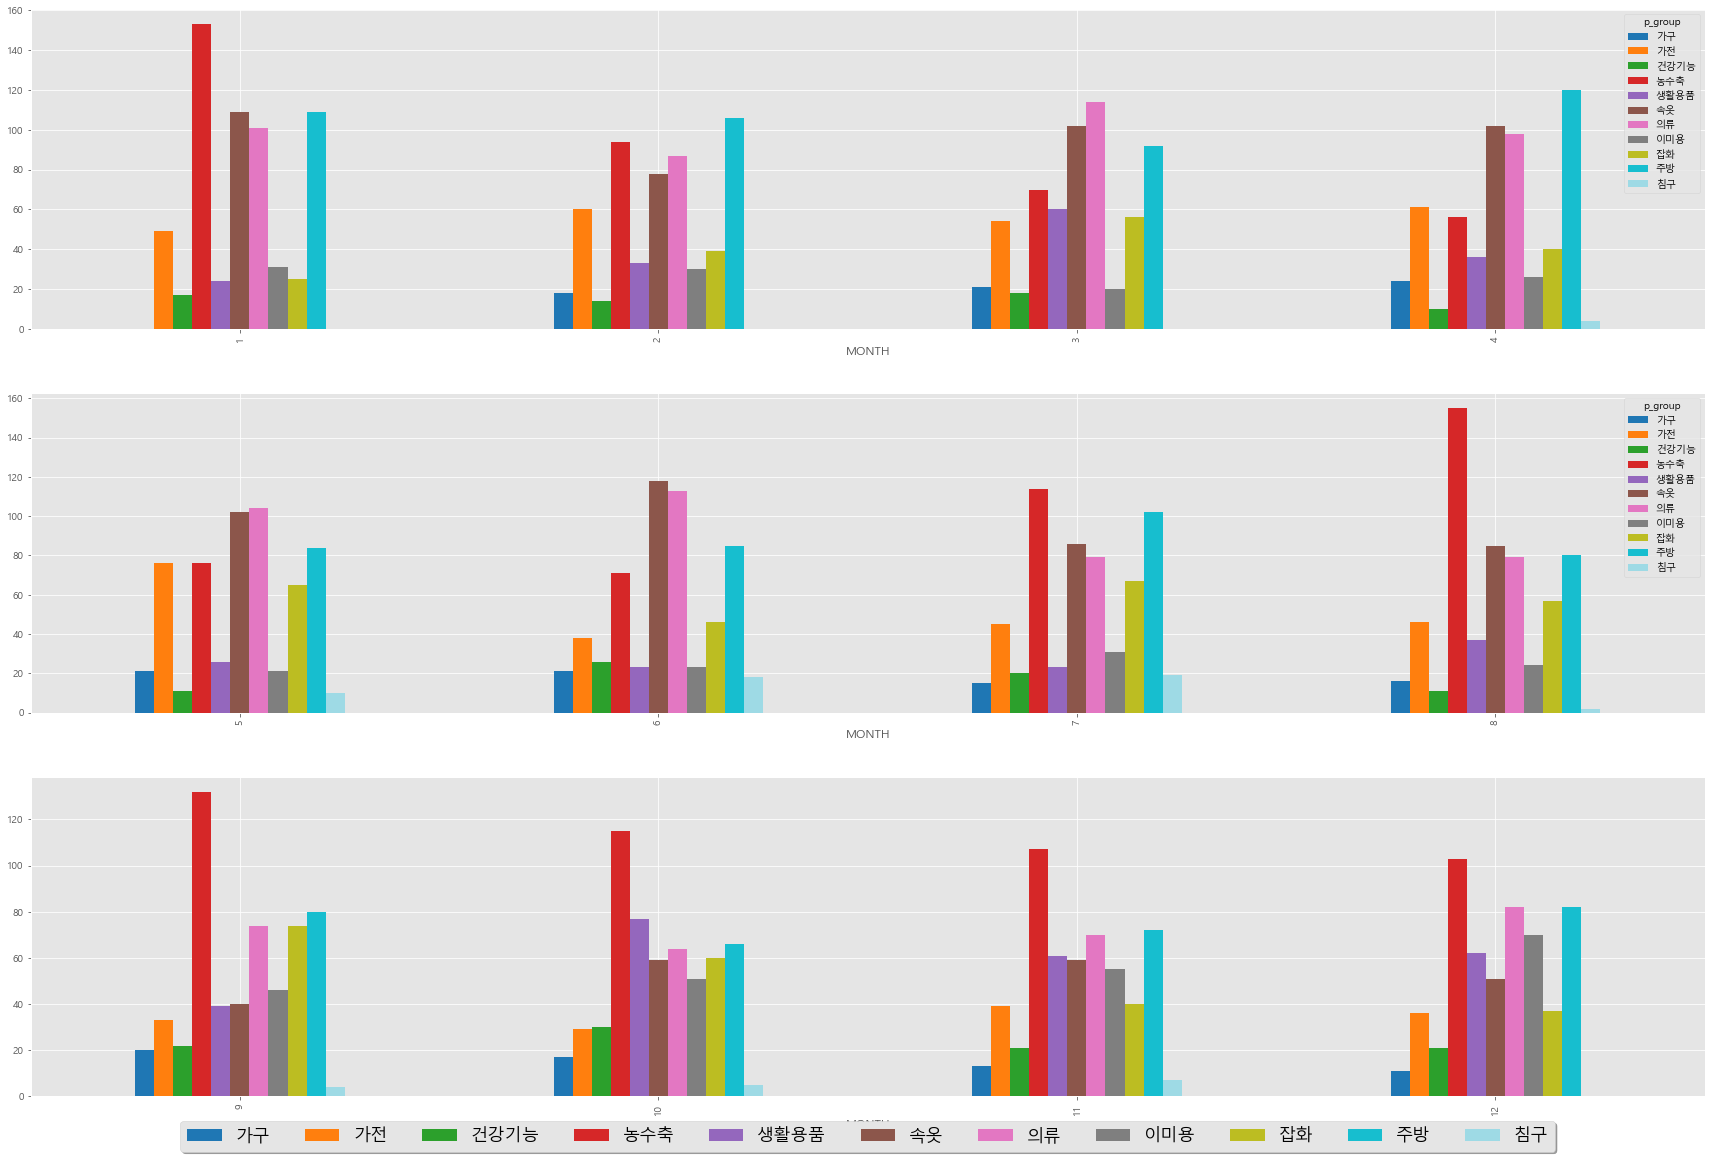

In [13]:
month_cnt = sum_df.groupby(['MONTH', 'p_group']).size()
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(30,20)

sum_df.groupby(['MONTH', 'p_group']).size().unstack()[:4].plot(kind='bar', colormap='tab20', ax=ax1)
sum_df.groupby(['MONTH', 'p_group']).size().unstack()[4:8].plot(kind='bar', colormap='tab20',ax=ax2)
sum_df.groupby(['MONTH', 'p_group']).size().unstack()[8:].plot(kind='bar', colormap='tab20',ax=ax3)

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
plt.show()

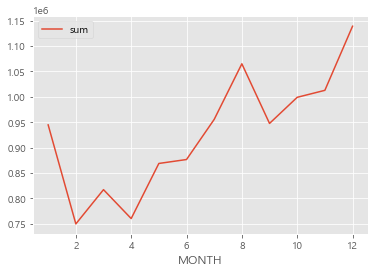

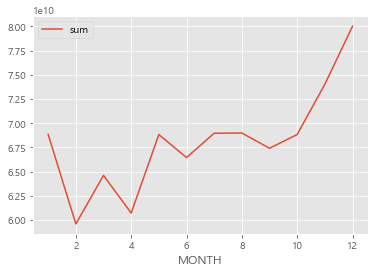

In [319]:
sum_df.groupby(['MONTH']).agg({'sales':['sum'],'total_price':['sum']})['sales'].plot()
sum_df.groupby(['MONTH']).agg({'sales':['sum'],'total_price':['sum']})['total_price'].plot()

* 농수축 = 

### 월별 mean =>  unit / sales/ total 

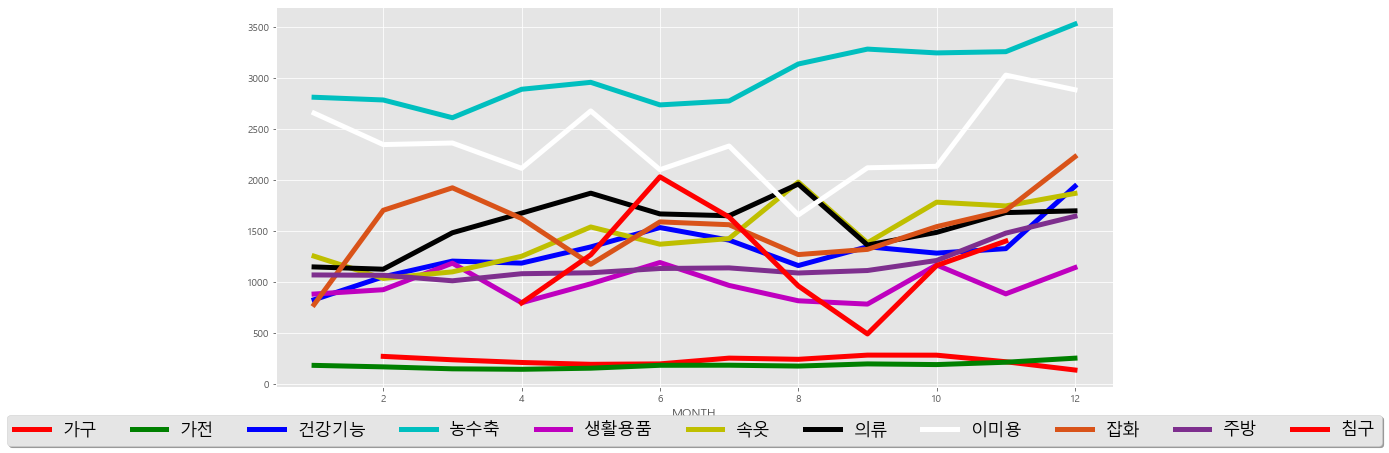

In [269]:
# 월별 방송횟수 (상품군별)
sum_df.groupby(['MONTH','p_group']).mean()['sales'].unstack().plot(figsize=(15,7),linewidth=5, color = ['r','g','b','c','m','y','k','w','#D95319','#7E2F8E'])
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
plt.show()

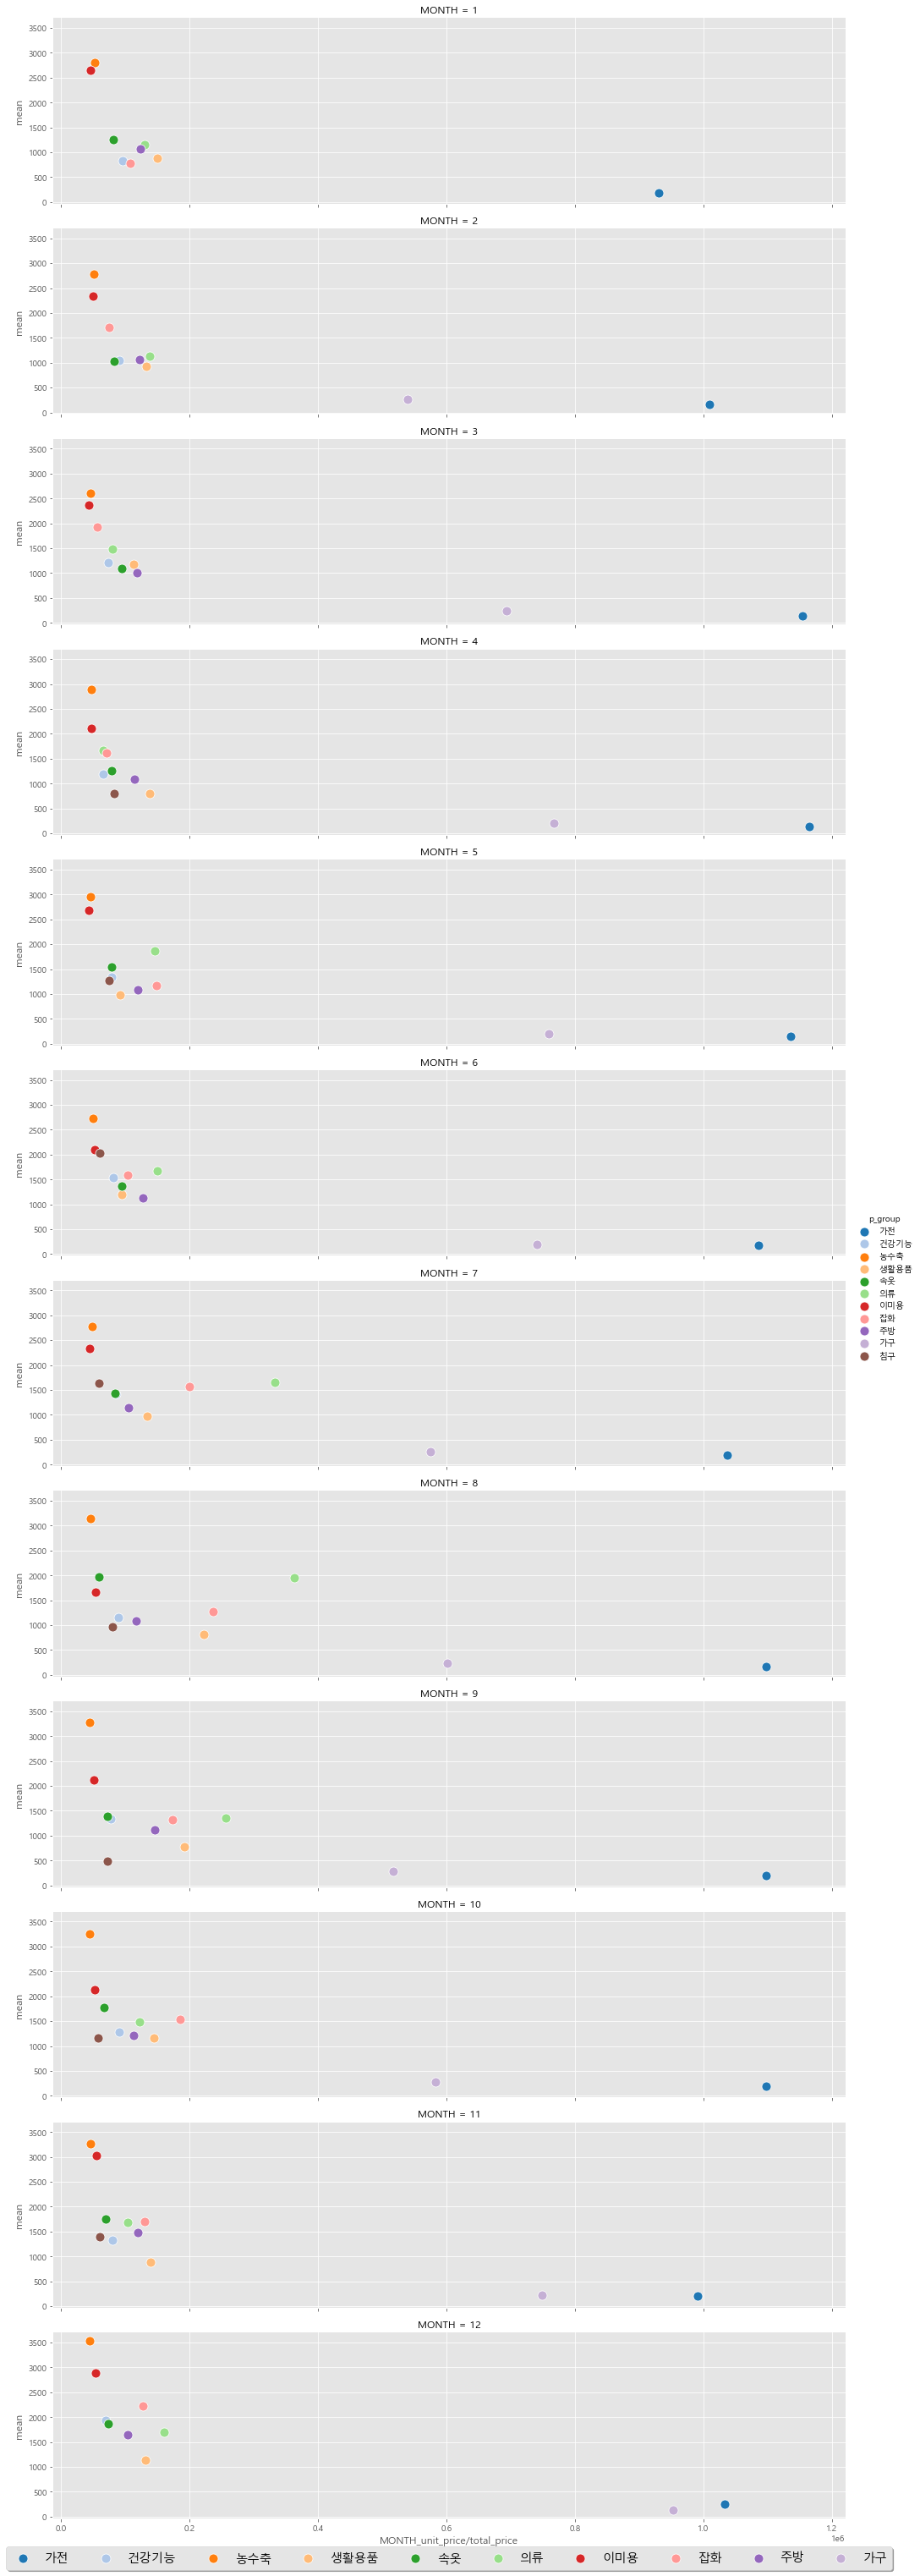

In [253]:
# 월별 x= unit_price / y=sales
month_mean = sum_df.groupby(['MONTH', 'p_group']).agg({'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
month_mean.columns=['unit_price','total_price','sales']
month_mean = month_mean.reset_index()

g = sns.FacetGrid(month_mean, row="MONTH",hue="p_group",palette='tab20',height=3.5,aspect=4)
g.map(sns.scatterplot, "unit_price", "sales",s=120)
g.set_axis_labels("MONTH_unit_price/total_price", "mean")
# g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
g.add_legend()

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.12), ncol=11, fancybox = True, shadow= True, fontsize= 'x-large')

### 월별 sum =>  unit / sales/ total 

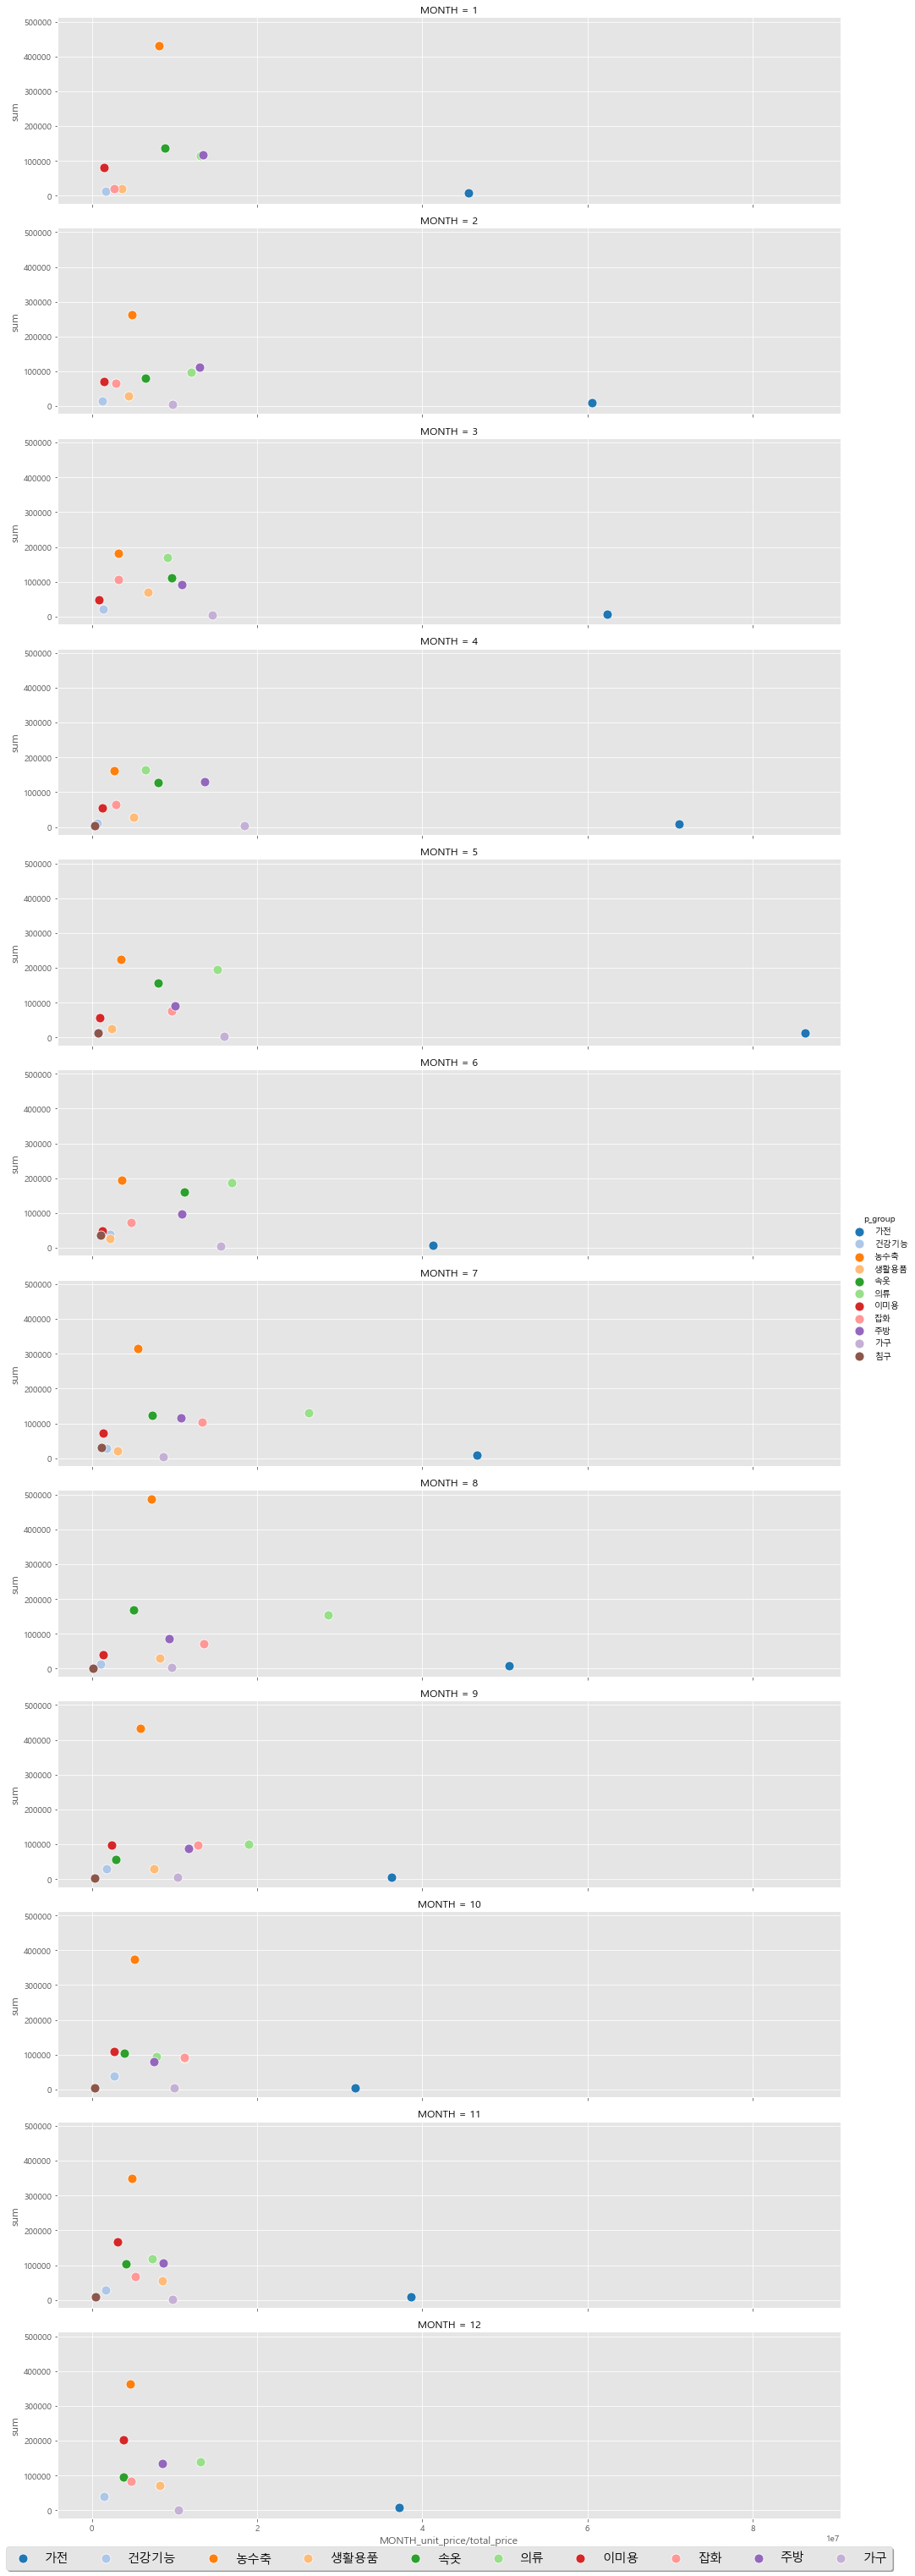

In [178]:
# 월별 x= unit_price / y=sales
month_sum = sum_df.groupby(['MONTH', 'p_group']).agg({'unit_price':['sum'], 'total_price':['sum'],'sales':['sum']})
month_sum.columns=['unit_price','total_price','sales']
month_sum = month_sum.reset_index()

g = sns.FacetGrid(month_sum, row="MONTH",hue="p_group",palette='tab20',height=3.5,aspect=4)
g.map(sns.scatterplot, "unit_price", "sales",s=120)
g.set_axis_labels("MONTH_unit_price/total_price", "sum")
# g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
g.add_legend()

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.12), ncol=11, fancybox = True, shadow= True, fontsize= 'x-large')

### 월별로 판매량 데이터 흐름 보기

In [249]:
#월별로 판매량 데이터 흐름 보기
def month_sales_plot(p_name):
    month_plot = sum_df.copy()
    month_plot['broadcast'] = month_plot['broadcast'].apply(pd.to_datetime)
    month_plot= month_plot.set_index('broadcast')
    print(month_plot[month_plot.p_group==p_name].sales.max())
    
    fig, axes = plt.subplots(12,1, figsize = (18,18))
    figure.set_size_inches(20,10)
    for idx, month in enumerate(sum_df.MONTH.unique()):
        g=month_plot.loc[(month_plot.MONTH==month) &(month_plot.p_group==p_name),:].loc['2019','sales'].plot(marker='o', linestyle='-',figsize=(8,19),ax=axes[idx], color='blue')
        g.set(ylim=(0, month_plot[month_plot.p_group==p_name].sales.max()+100)) # x, y scale 조정
        

1063.0


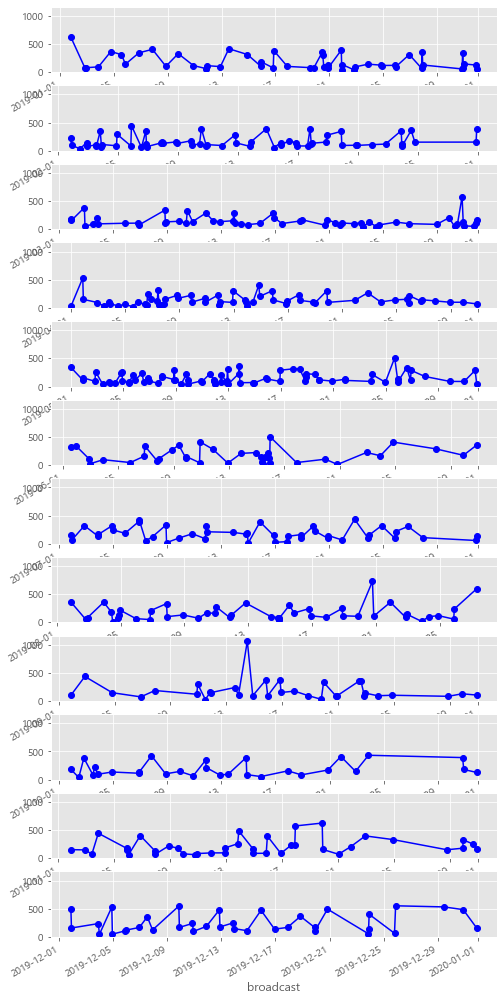

In [250]:
month_sales_plot('가전')

In [240]:
def month_sum_p_group(p_name):
    sum_df
    month_sum_group = sum_df.loc[sum_df.p_group==p_name,:][['broadcast','MONTH','exp_min', 'unit_price','total_price','sales']]
#     month_sum_group.columns=['exp_min','unit_price','total_price','sales']
#     month_sum_group =month_sum_group.reset_index()
#     month_sum_group

    g = sns.FacetGrid(month_sum_group, row="MONTH",palette='tab20',height=2.5,aspect=7)
    g.map(sns.pointplot,"broadcast", "sales", s=120)
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='large', rotation=45)

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



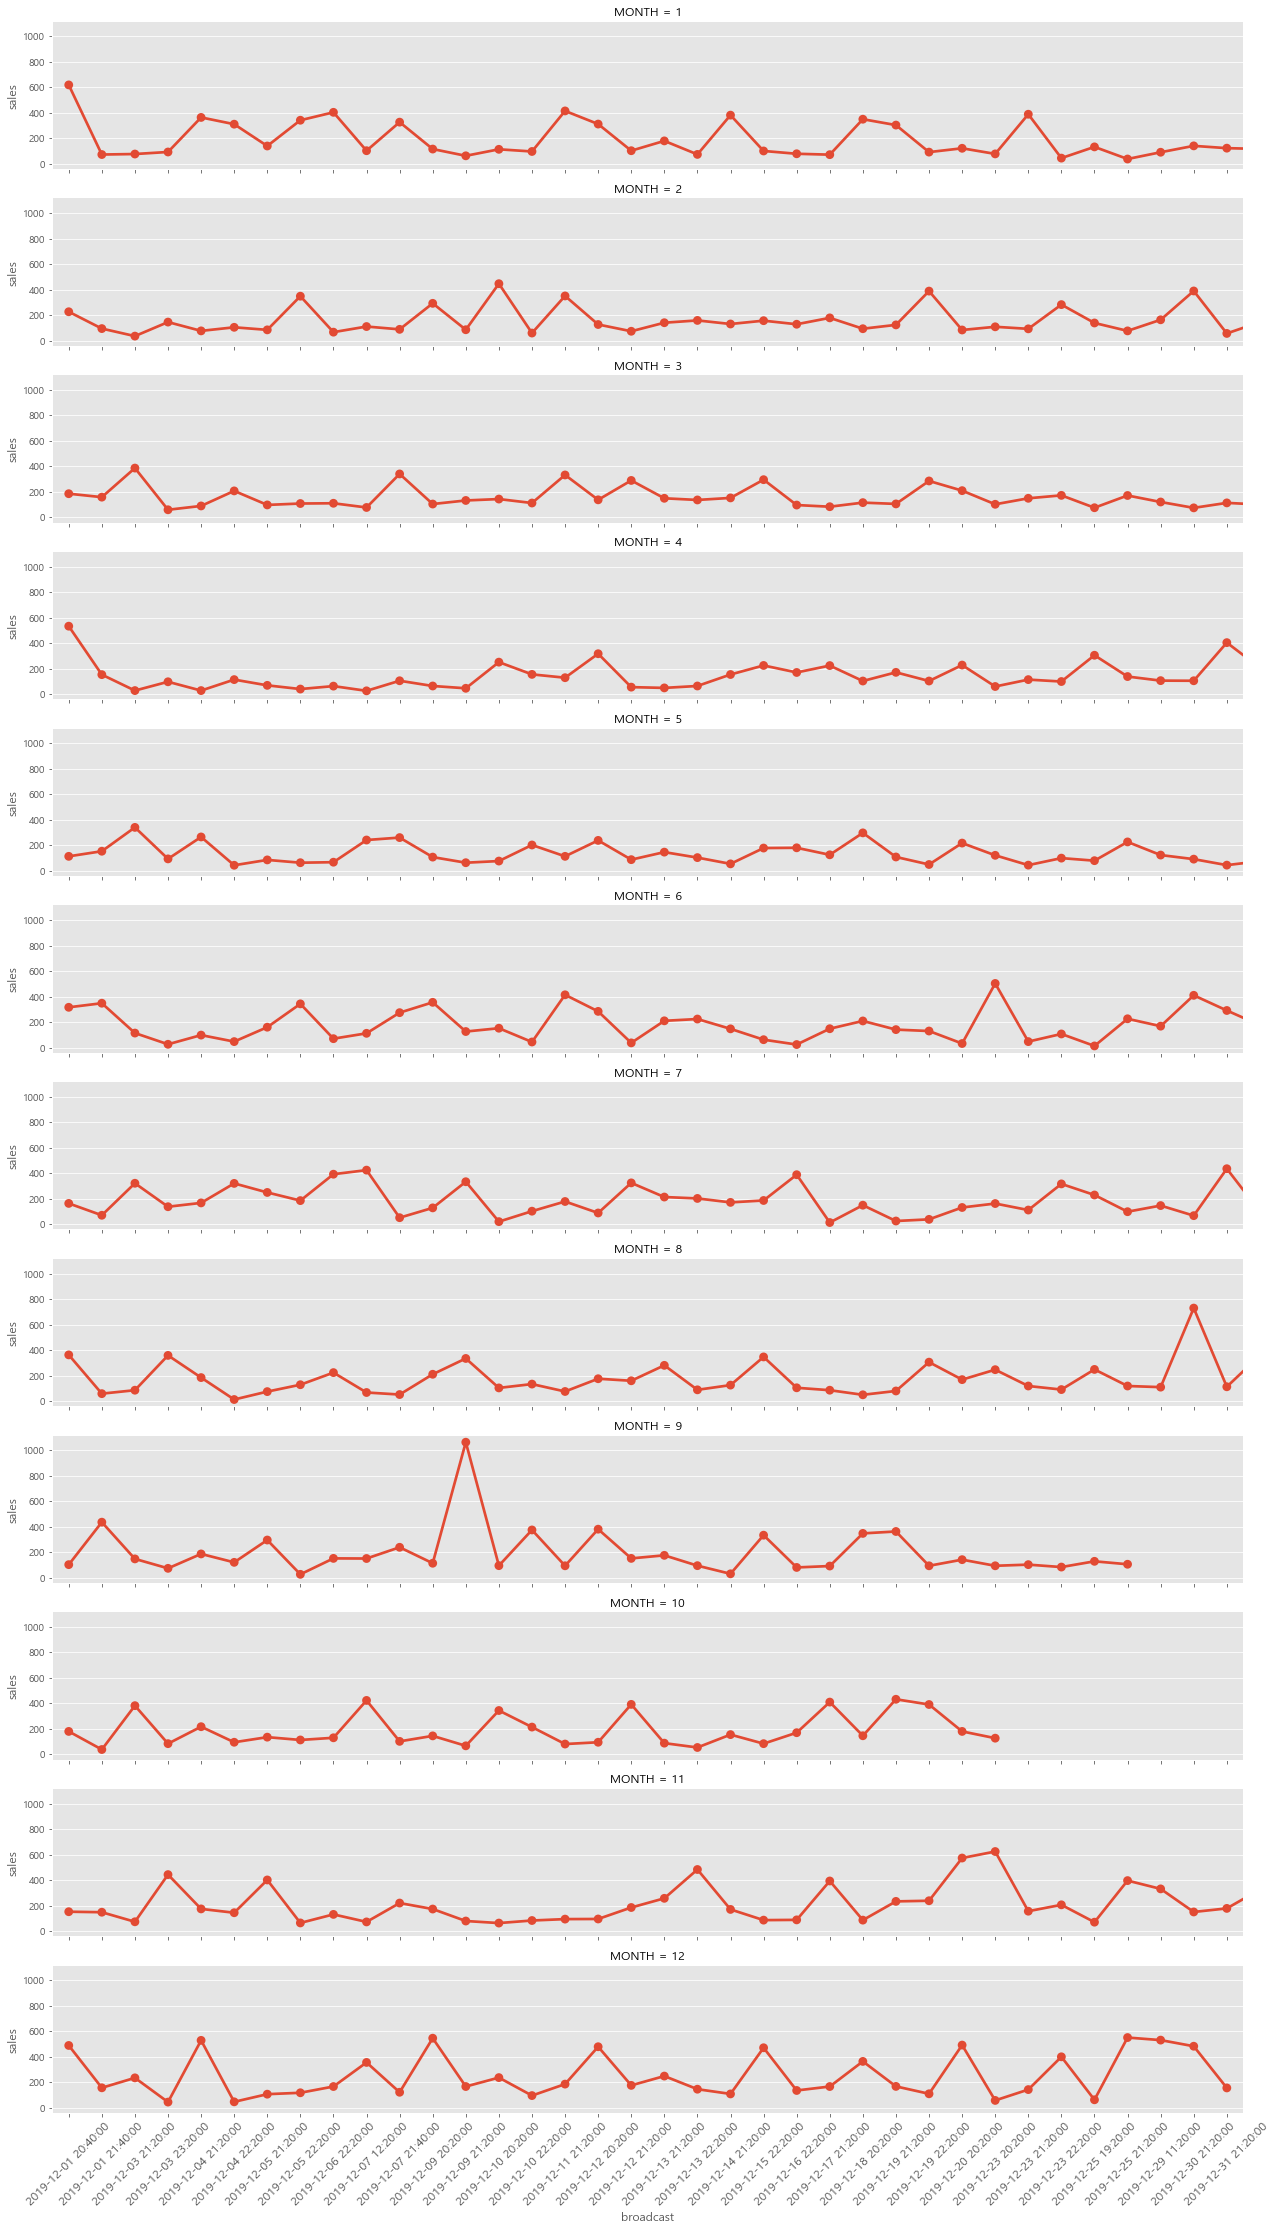

In [49]:
month_sum_p_group('가전')

In [ ]:
def wkday_month_mean(p_name):
    wkd_month_mean = sum_df.groupby(['DAY_NAME','MONTH', 'p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], row="DAY_NAME",palette='tab20',height=2.5,aspect=2.5)
    g.map(sns.pointplot,"MONTH", "sales", s=120)
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large')

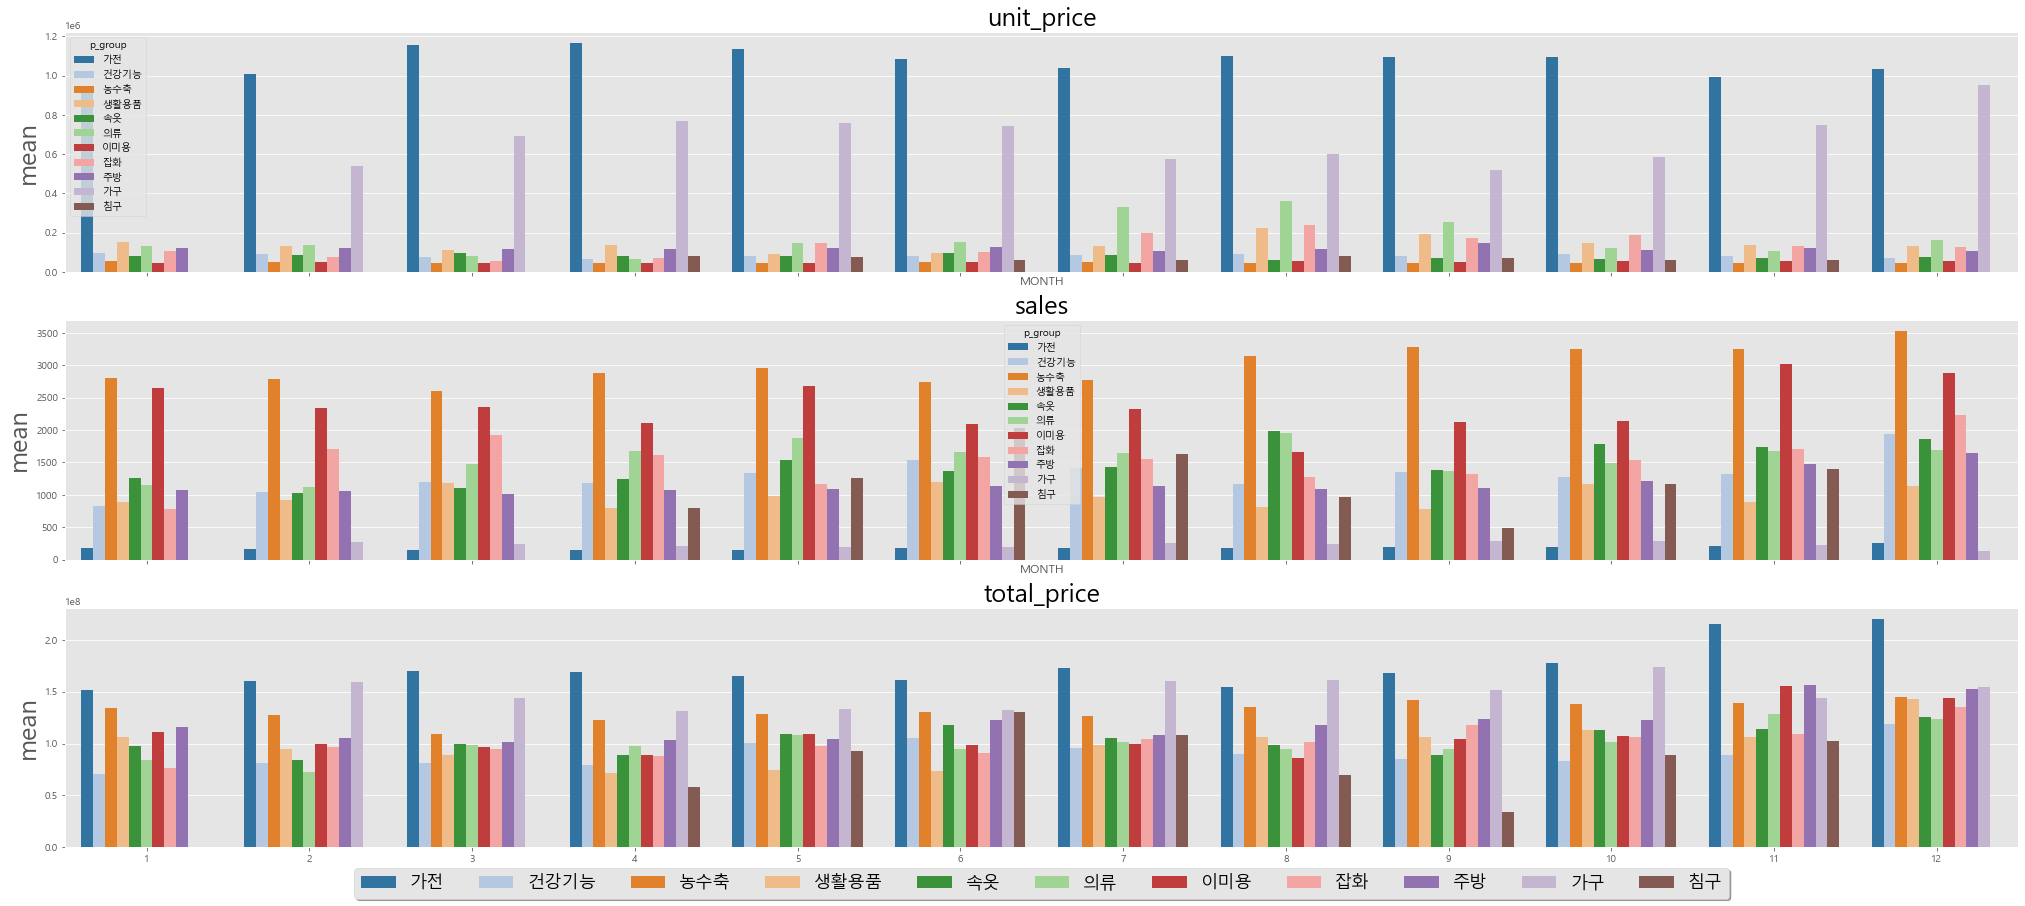

In [96]:
month_mean = sum_df.groupby(['MONTH', 'p_group']).agg({'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
month_mean.columns=['unit_price','total_price','sales']
month_mean = month_mean.reset_index()

fig, axes = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
for name, ax in zip(['unit_price', 'sales','total_price'], axes):
    sns.barplot(data=month_mean, x='MONTH', y=name, hue='p_group',palette='tab20', ax=ax)
    ax.set_ylabel('mean', fontsize=25)
    ax.set_title(name, fontsize=25)

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-2]:
    ax.set_xlabel('')

mean & sum 두개 다 보는데 어떤 것을 봐야할지 아직 감이 오지 않음
sum으로 보면 단점 1. 어떤 상품군이 방송을 많이 했을 때, 그만큼 sum이 높아짐
* 가전 => 
* 건강기능 => 5,6, 12월달 판매량 많음 (단가도 5,6월에 낮다) => 부모님 선물 타겟인가
* 농수축 => 8,9,10,11,12월달 판매량 많음 => 수확시기와 맞물리나? 상품군을 세분화해서 봐야겠다고 생각 => 어떠한 것을 파았는지 보자/ 겨울로 갈 수록 단가가 높아지느 ㄴ경향있음

* 생활용품 => 6월 > 3월 > >>> 9월 => 이유는 모르겠음
* 속옷 => 5월>4월 많음 => 주니어/ 풍기인견 / 심리스 / 초특가 / 
          8, / 10, 11,12 => 8월(초특가) / 


## 2.요일대별
* 달(1월 - 12월)
* 분기(1,2,3 / 4,5,6 / 7,8,9 / 10,11,12)
* 계절(봄 =3,4,5/ 여름=6,7,8 / 가을=9,10,11 / 겨울=12,1,2)
* 공휴일 vs 공휴일 아닐 때

### 1) 요일 & 월별 -> 상품군별

In [271]:
sum_df.keys()

Index(['broadcast', 'exp_min', 'm_code', 'p_code', 'p_name', 'p_group',
       'unit_price', 'total_price', 'sales', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'SECOND', 'YEAR_DAY', 'DAY_NAME', 'DAY_NUM', 'p_group_code',
       'new_code', 'no', 'sales_level', 'grade', 'quarter', 'timeslot',
       'season'],
      dtype='object')

In [275]:
sum_df.groupby(['DAY_NUM','MONTH','p_group']).mean()['sales']

DAY_NUM  MONTH  p_group
1        1      가전          257.600000
                건강기능        560.000000
                농수축        2834.840000
                생활용품        743.250000
                속옷         1229.866667
                              ...     
7        12     속옷         1843.272727
                의류         1878.235294
                이미용        3719.538462
                잡화         3753.000000
                주방         2200.750000
Name: sales, Length: 852, dtype: float64

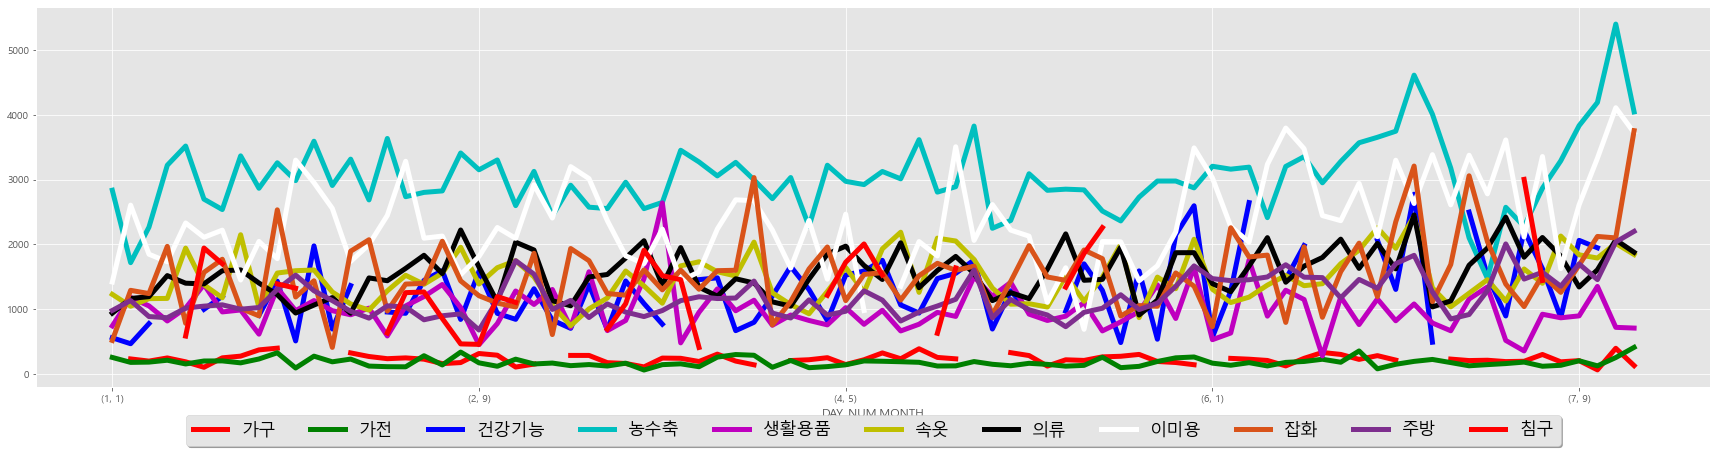

In [276]:
# 요일별 월별 slaes (상품군별)
sum_df.groupby(['DAY_NUM','MONTH','p_group']).mean()['sales'].unstack().plot(figsize=(30,7),linewidth=5, color = ['r','g','b','c','m','y','k','w','#D95319','#7E2F8E'])
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
plt.show()

In [365]:
def wkday_month_mean(p_name):
    wkd_month_mean = sum_df.groupby(['DAY_NAME','MONTH', 'p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], row="DAY_NAME",palette='tab20',height=2.5,aspect=2.5)
    g.map(sns.pointplot,"MONTH", "sales", s=120)
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large')
    
def month_wkday_mean(p_name):
    wkd_month_mean = sum_df.groupby(['DAY_NAME','MONTH', 'p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], row="MONTH",hue='p_group', palette='tab20',height=2.5,aspect=2.5)
    g.map(sns.pointplot,"DAY_NAME", "sales", s=120)
    # g.set_axis_labels("MONTH_unit_price/total_price", "sum")
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large',rotation=45)

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



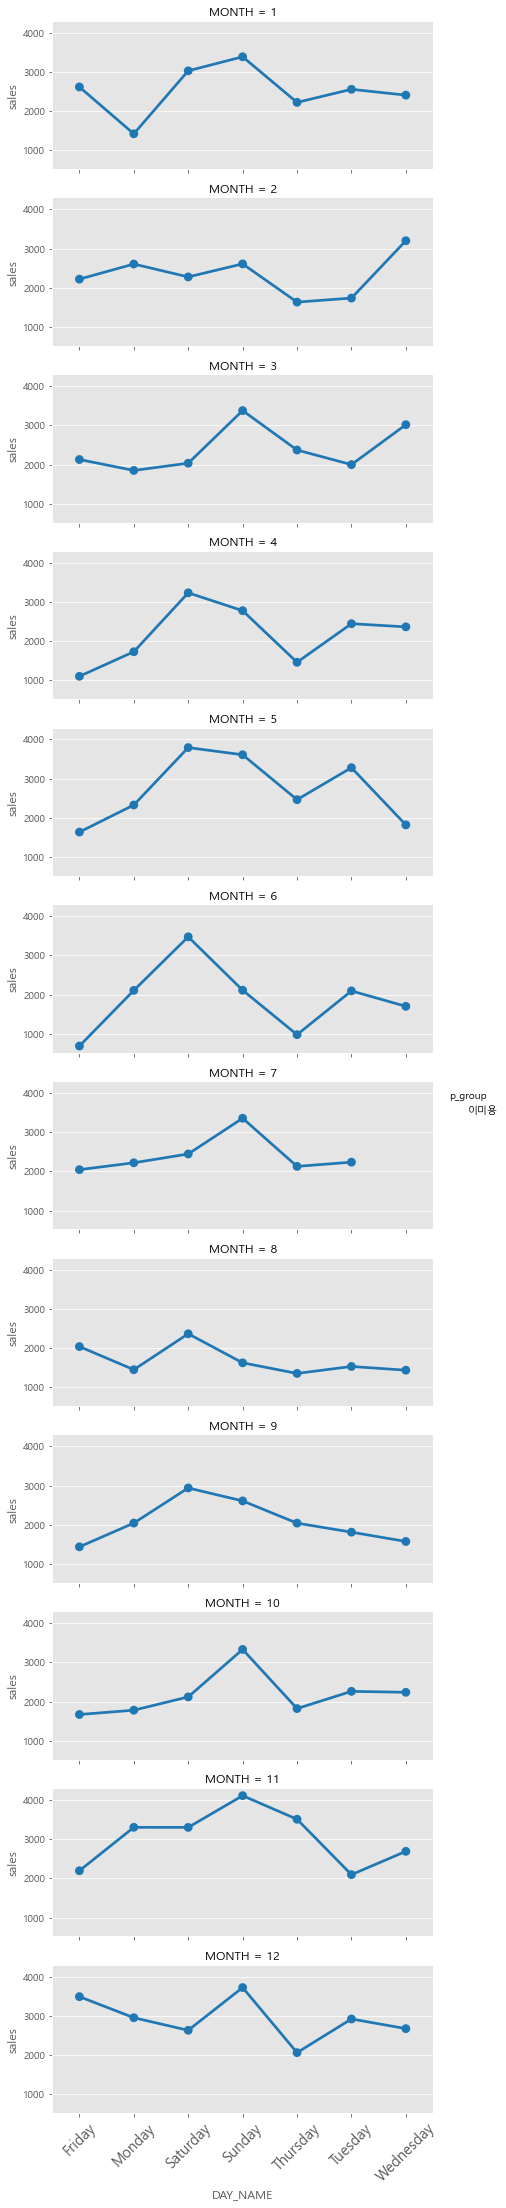

In [366]:
month_wkday_mean('이미용') # 요일별 -> 월별 -> p_group -> mean

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



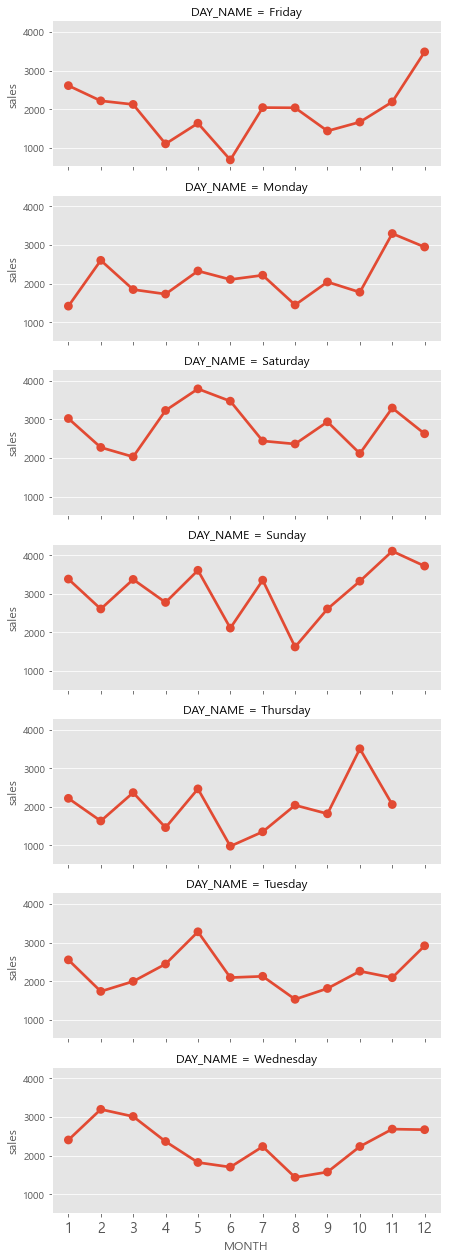

In [367]:
wkday_month_mean('이미용') # 월별 -> 요일별 -> p_group -> mean

### 2) 분기 & 요일 -> 상품군별

In [384]:
def quarter_wkday_mean(p_name):
    wkd_month_mean = sum_df.groupby(['quarter', 'DAY_NAME','p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], col="quarter",palette='tab20',height=2.5,aspect=2)
    g.map(sns.pointplot,"DAY_NAME", "sales", s=120)
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large', rotation=45)
    
def wkday_quarter_mean(p_name):
    wkd_month_mean = sum_df.groupby(['DAY_NAME','quarter', 'p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], row="DAY_NAME",hue='p_group', palette='tab20',height=2.5,aspect=2)
    g.map(sns.pointplot,"quarter", "sales", s=120)
    # g.set_axis_labels("MONTH_unit_price/total_price", "sum")
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large',rotation=45)

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



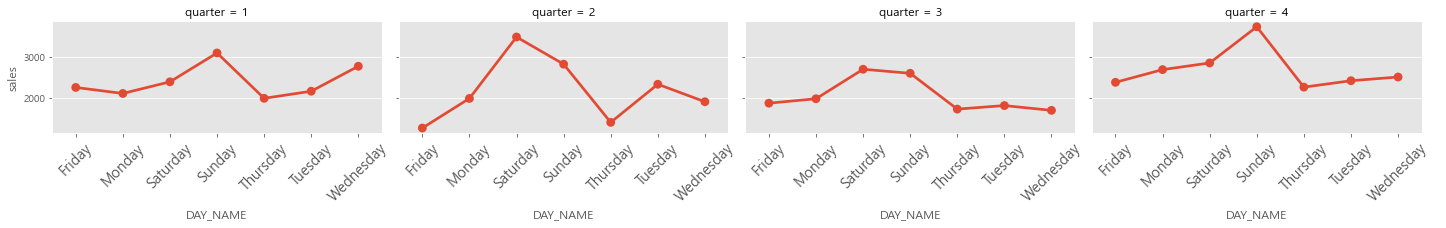

In [385]:
quarter_wkday_mean('이미용')

1,4 분기와 / 3,4 분기의 경향이 비슷하다

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



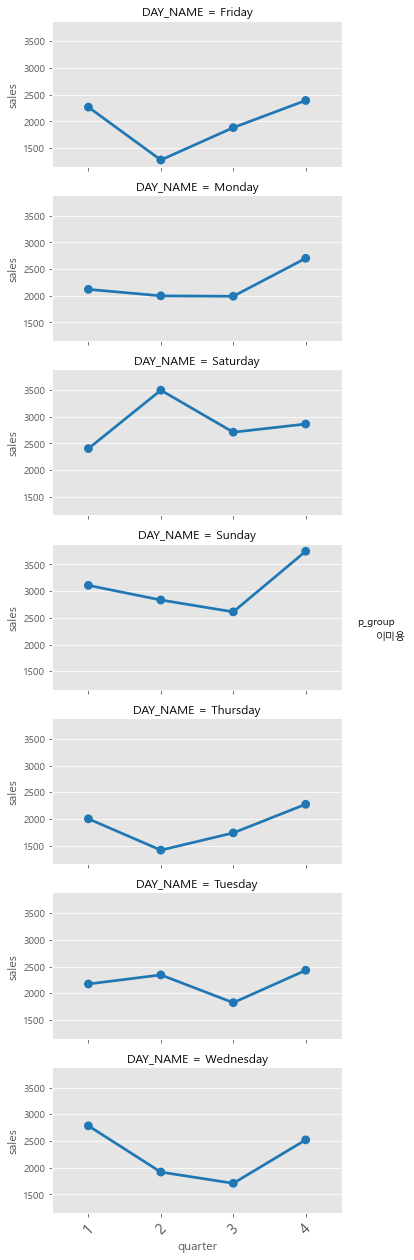

In [386]:
wkday_quarter_mean('이미용')

금& 목 / 월& 일  비슷

### 3) 계절 & 요일 -> 상품군별

In [387]:
def season_wkday_mean(p_name):
    wkd_month_mean = sum_df.groupby(['season', 'DAY_NAME','p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], col="season",palette='tab20',height=2.5,aspect=2)
    g.map(sns.pointplot,"DAY_NAME", "sales", s=120)
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large', rotation=45)
    
def wkday_season_mean(p_name):
    wkd_month_mean = sum_df.groupby(['DAY_NAME','season', 'p_group']).agg({'exp_min':['sum'],'unit_price':['mean'], 'total_price':['mean'],'sales':['mean']})
    wkd_month_mean.columns=['exp_min','unit_price','total_price','sales']
    wkd_month_mean =wkd_month_mean.reset_index()
    
    g = sns.FacetGrid(wkd_month_mean.loc[wkd_month_mean.p_group==p_name,:], row="DAY_NAME",hue='p_group', palette='tab20',height=2.5,aspect=2)
    g.map(sns.pointplot,"season", "sales", s=120)
    # g.set_axis_labels("MONTH_unit_price/total_price", "sum")
    # g.set(xlim=(0, 60), ylim=(0, 12)) # x, y scale 조정
    g.add_legend()
    g.set_xticklabels(fontsize='x-large',rotation=45)

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



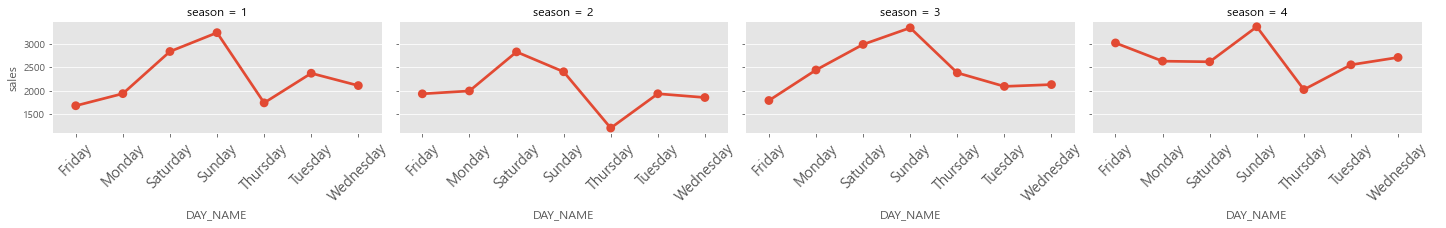

In [389]:
season_wkday_mean('이미용')

봄. 가을 비슷

C:\Users\johc5\.conda\envs\multi\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



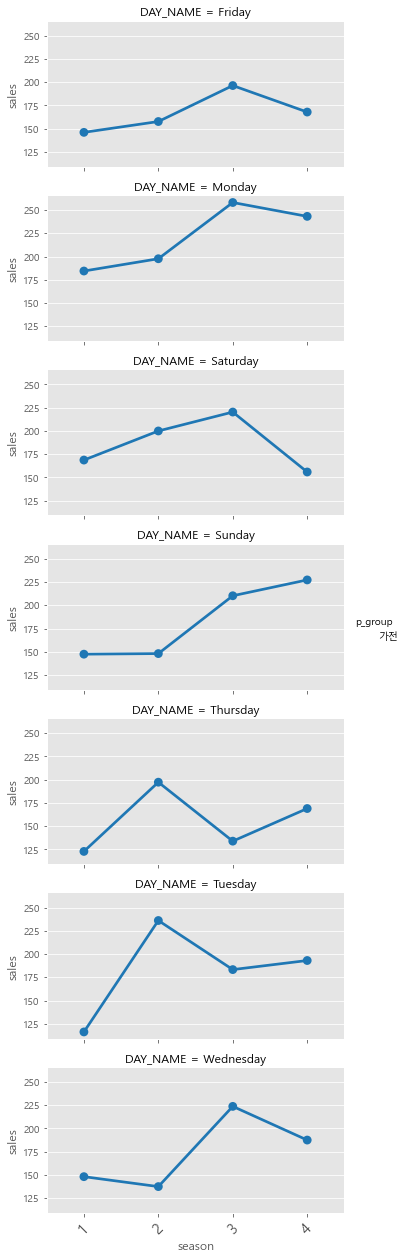

In [378]:
wkday_season_mean('가전')

가전 =>금&월 / 화&목 

In [304]:
sum_df.groupby(['m_code', 'p_code','p_name']).agg({'exp_min':['sum'],'unit_price':['mean'],'sales':['']})

exp_min  unit_price  total_price  \
m_code p_code p_name                 sales                                      
100000 200000 엘로엘 아쿠아클린 마스크          363.0      55.0       79900   28951000.0   
                                     596.0      60.0       79900   47611000.0   
100001 200001 국내생산 스텐락 심플 스텐밀폐용기 17종 649.0      60.0       99000   64274000.0   
                                     880.0      60.0       99000   87062000.0   
100002 200002 이보은의 우삽겹 12팩세트         2068.0     60.0       49900  103206000.0   
...                                              ...         ...          ...   
100849 202513 멋진밥상 흥양농협 햅쌀 20kg      2894.0     60.0       58900  170446000.0   
                                     3039.0     60.0       58900  178950000.0   
                                     3323.0     60.0       58900  195763000.0   
                                     3889.0     60.0       58900  229084000.0   
                                     4833.0     40.0       58900  284680000.0   

                                             YEAR  MONTH  DAY  HOUR  MINUTE  \
m_code p_code p_name                 sales                                    
100000 200000 엘로엘 아쿠아클린 마스크          363.0   2019      8   29    25       0   
                                     596.0   2019      8   25    24      20   
100001 200001 국내생산 스텐락 심플 스텐밀폐용기 17종 649.0   2019      2    1    13       0   
                                     880.0   2019      1   25    16       0   
100002 200002 이보은의 우삽겹 12팩세트         2068.0  2019     11    1    17      20   
...                                           ...    ...  ...   ...     ...   
100849 202513 멋진밥상 흥양농협 햅쌀 20kg      2894.0  2019     10   24    18       0   
                                     3039.0  2019     11   12    18      20   
                                     3323.0  2019     10   28    17       0   
                                     3889.0  2019     10   18    17       0   
                                     4833.0  2019     11    2    17      20   

                                             SECOND  DAY_NUM  p_group_code  \
m_code p_code p_name                 sales                                   
100000 200000 엘로엘 아쿠아클린 마스크          363.0        0        4             4   
                                     596.0        0        7             4   
100001 200001 국내생산 스텐락 심플 스텐밀폐용기 17종 649.0        0        5             2   
                                     880.0        0        5             2   
100002 200002 이보은의 우삽겹 12팩세트         2068.0       0        5             3   
...                                             ...      ...           ...   
100849 202513 멋진밥상 흥양농협 햅쌀 20kg      2894.0       0        4             3   
                                     3039.0       0        2             3   
                                     3323.0       0        1             3   
                                     3889.0       0        5             3   
                                     4833.0       0        6             3   

                                             new_code     no  grade  quarter  \
m_code p_code p_name                 sales                                     
100000 200000 엘로엘 아쿠아클린 마스크          363.0     5119.0  25620      4        3   
                                     596.0     5039.0  25275      4        3   
100001 200001 국내생산 스텐락 심플 스텐밀폐용기 17종 649.0      638.0   2921      3        1   
                                     880.0      499.0   2310      3        1   
100002 200002 이보은의 우삽겹 12팩세트         2068.0    6448.0  32262      3        4   
...                                               ...    ...    ...      ...   
100849 202513 멋진밥상 흥양농협 햅쌀 20kg      2894.0    6285.0  31533      3        4   
                                     3039.0    6888.0  33367      2        4   
                                     3323.0    6370.0  31885      2        4   
                                     3889.0    6160.0  30869      2 

In [298]:
sum_df.groupby(['m_code', 'p_code','p_name']).size().sort_values(ascending=False).head(60)

m_code  p_code  p_name                              
100253  200864  안동간고등어 20팩                              106
100255  200868  한일 대용량 스텐 분쇄믹서기                          94
100150  200533  일시불 LG 통돌이 세탁기                           91
100010  200014  AAB의 소곱창전골 800g x 8팩                     84
100849  202510  멋진밥상 흥양농협 쌀 20kg                         73
100088  200236  에코라믹 통주물 스톤 냄비세트                         66
100155  200556  일시불 LG전자 매직스페이스 냉장고                      64
100837  202467  무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS)          63
100448  201378  (쿠)일시불 19년 신제품  쿠첸 풀스텐 압력밥솥 10인용(A1)     59
100097  200269  일시불 올리고 가스와이드그릴  프리미엄형                   58
100322  201479  국내산 손질갑오징어 8팩                            54
100074  200197  비버리힐스폴로클럽 남성기초세트(2018FW골드)               50
100205  200733  보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글         49
100202  200685  임성근의 녹용도가니탕 풀세트                          47
100766  202239  참존 탑뉴스 지이링클 기초세트                         46
100841  202484  옛날 그 쥐포 110장 (11팩)             

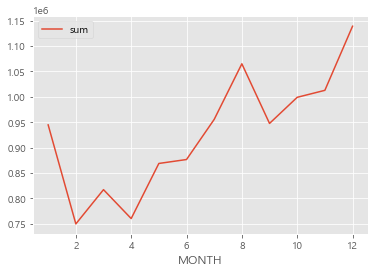

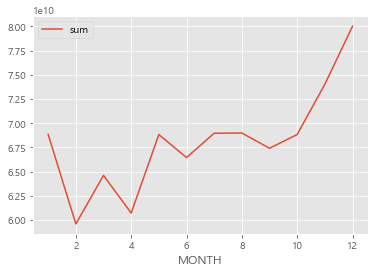

In [327]:
month = sum_df.groupby(['MONTH']).agg({'exp_min':['sum'], 'total_price':['sum'],'sales':['sum']})
month['sales'].plot()
month['total_price'].plot()

### 방송횟수 요일별 집계

In [384]:
sum_df.head()

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NAME,DAY_NUM,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,32696000.0,820.0,2019,...,Tuesday,2,0,13.0,0,b,4,1,1,4
1,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,47878000.0,812.0,2019,...,Tuesday,2,1,7.0,6,b,4,1,1,4
2,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,99736000.0,1665.0,2019,...,Tuesday,2,0,16.0,9,d,3,1,1,4
3,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,의류,79000,90973000.0,1151.0,2019,...,Tuesday,2,0,18.0,12,c,3,1,2,4
4,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,259678000.0,3250.0,2019,...,Tuesday,2,0,17.0,15,e,2,1,2,4


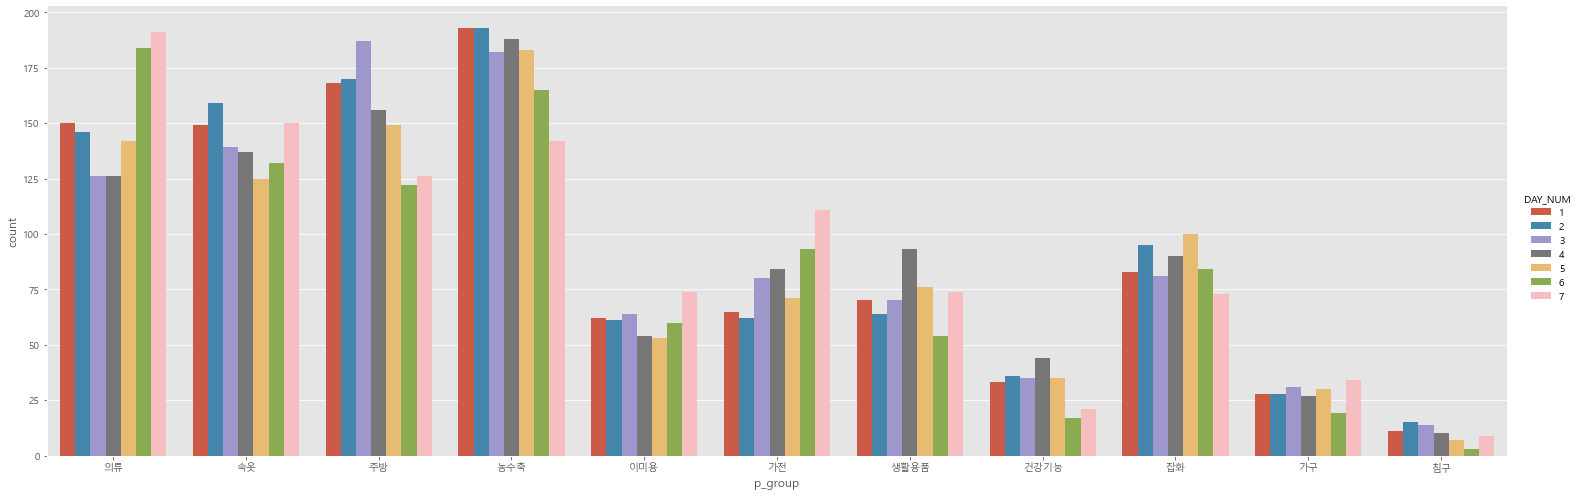

In [399]:
# 상품군별 요일 방송 횟수 통계
sns.factorplot("p_group", data=sum_df, hue='DAY_NUM',kind="count", size=7, aspect=3)
plt.show()

<방송 편성 횟수>
* 의류 = 주말> 월화금 > 수목
* 속옥 = 화> 월,일> 수목토> 금
* 주방 = 수> 월, 화 > 목금 > 일> 토
* 농수축 = 월화목 > 수,금> 토> 일
* 이미용 = 일> 월화수토 > 수목
* 가전 = 일>토> 수목> 금> 월화
* 생활용품 = 목> 금,일> 월화수> 토
* 건강기능 = 목> 월화수금> 일> 토
* 잡화 = 화금> 목> 월수토> 일
* 가구 = 일> 수,금> 월화목> 토
* 침구 = 화수> 월목> 금일> 토


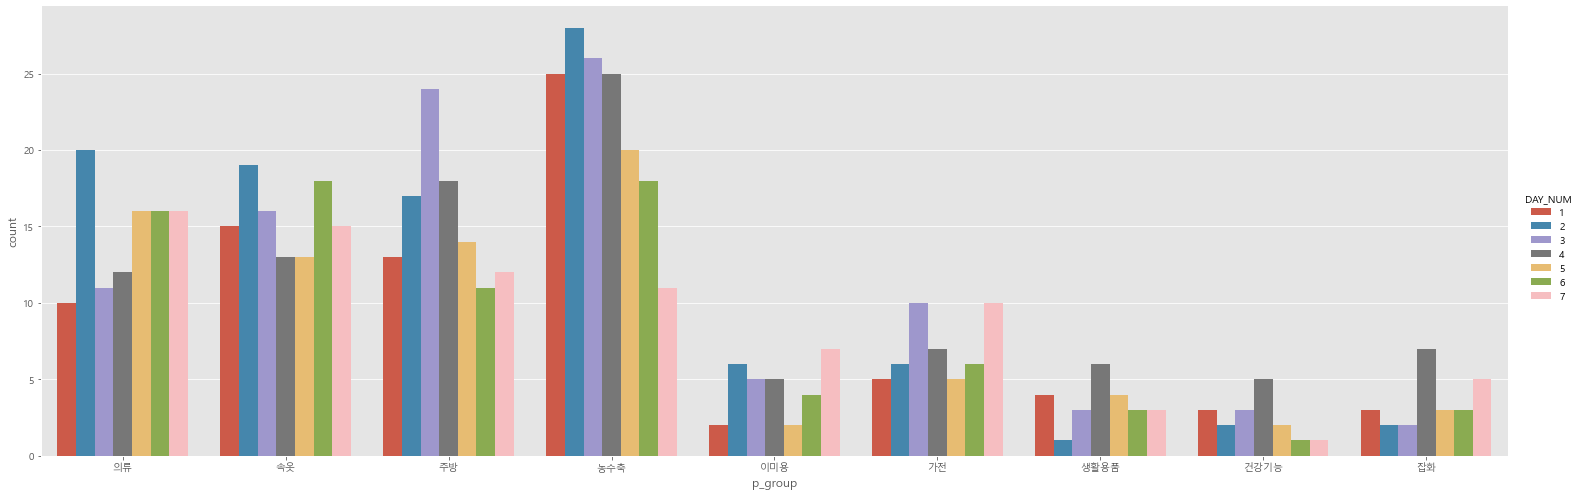

In [451]:
# 요일별 방송 횟수 count

sns.factorplot(x="p_group", data=sum_df.loc[sum_df.MONTH==1,:], hue='DAY_NUM',kind="count", size=7, aspect=3)
plt.fontsize=18
plt.show()

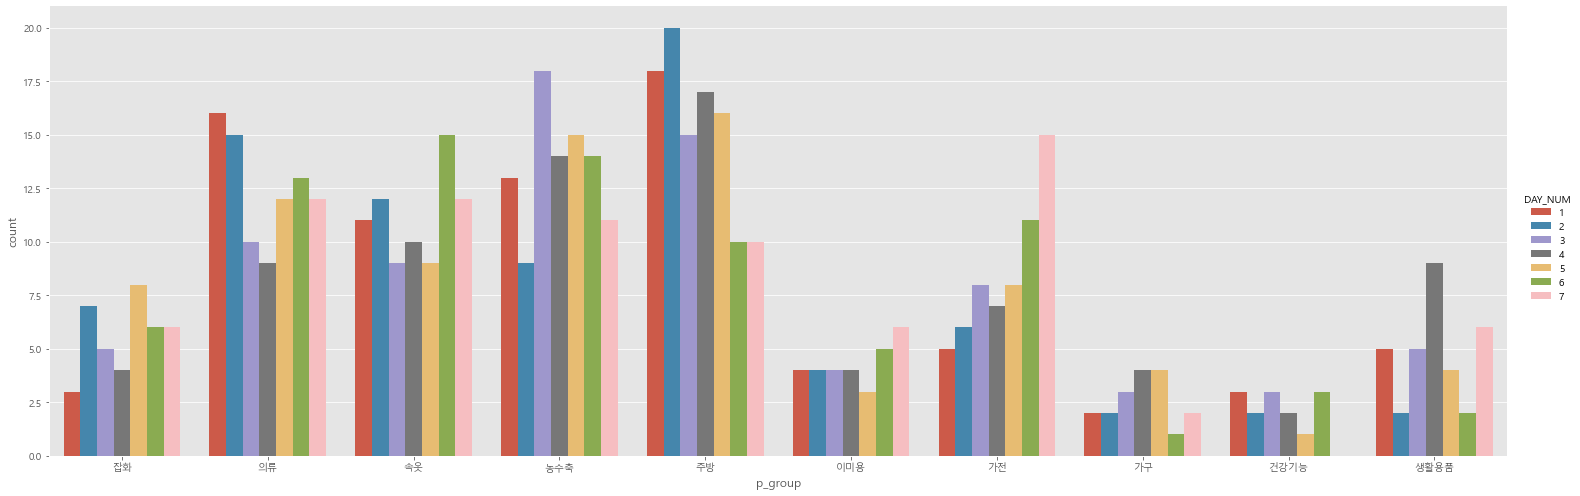

In [406]:
sns.factorplot("p_group", data=sum_df.loc[sum_df.MONTH==2,:], hue='DAY_NUM',kind="count", size=7, aspect=3)
plt.show()

# 침구 관련된 상품 언제 잘 팔렸을까?

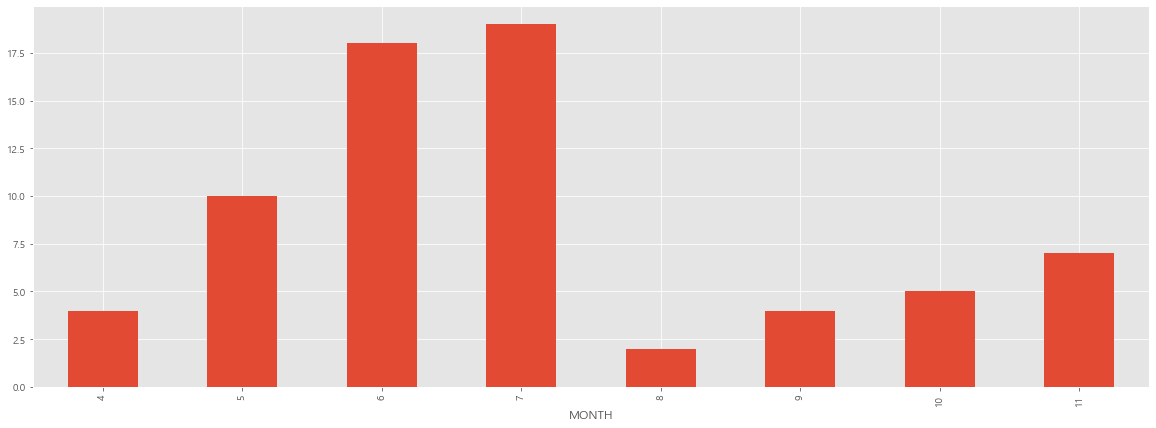

In [510]:
sum_df[sum_df.p_group=='침구'].groupby(['MONTH']).size().plot(kind='bar', figsize=(20,7))

Text(0.5, 1.0, 'MONTH/ timeslot으로 방송횟수 보기')

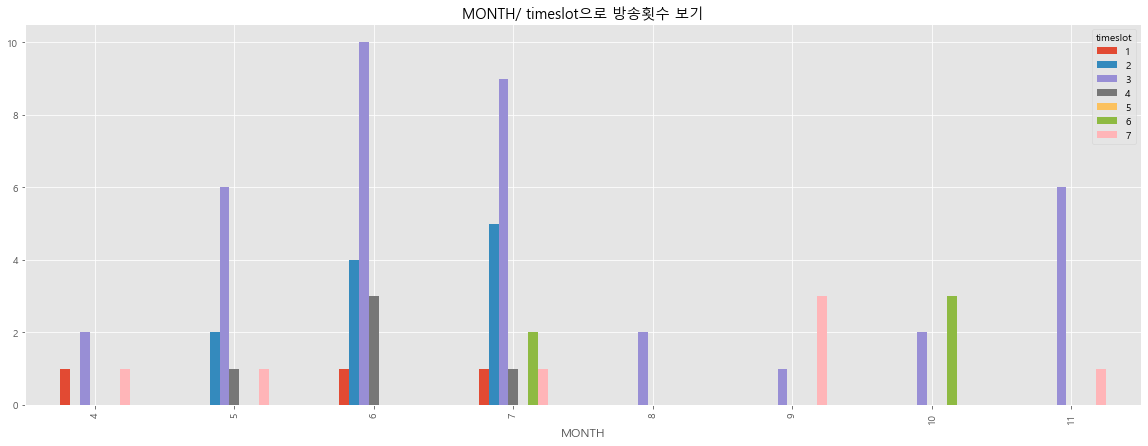

In [505]:
# 월별 timeslot으로 나눠서 방송count 보기
sum_df[sum_df.p_group=='침구'].groupby(['MONTH','timeslot']).size().unstack().plot(kind='bar', figsize=(20,7))
plt.title('MONTH/ timeslot으로 방송횟수 보기')

Text(0.5, 1.0, 'MONTH/ timeslot 별로 sales [sum] 결과값')

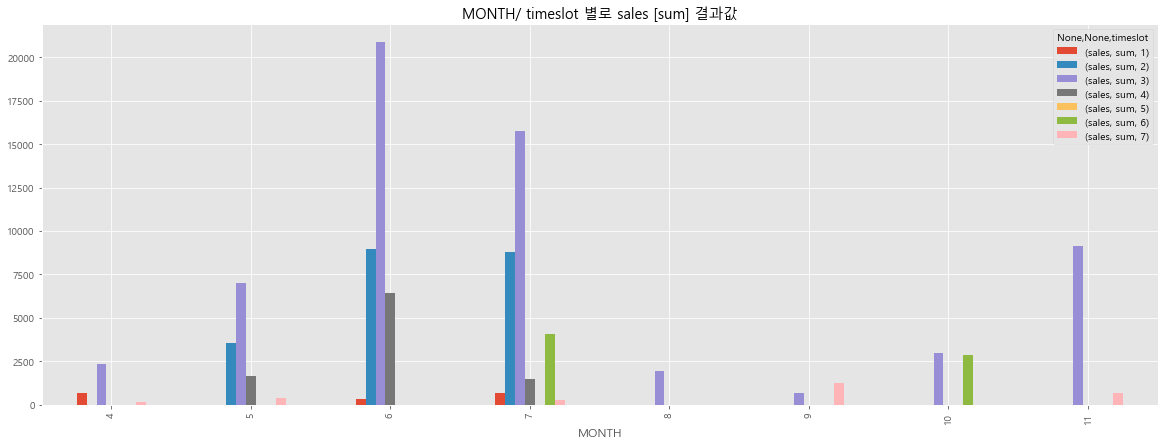

In [503]:
sum_df[sum_df.p_group=='침구'].groupby(['MONTH','timeslot']).agg({'sales':['sum']}).unstack().plot(kind='bar', figsize=(20,7))
plt.title('MONTH/ timeslot 별로 sales [sum] 결과값')

Text(0.5, 1.0, 'MONTH/ timeslot 별로 sales [mean] 결과값')

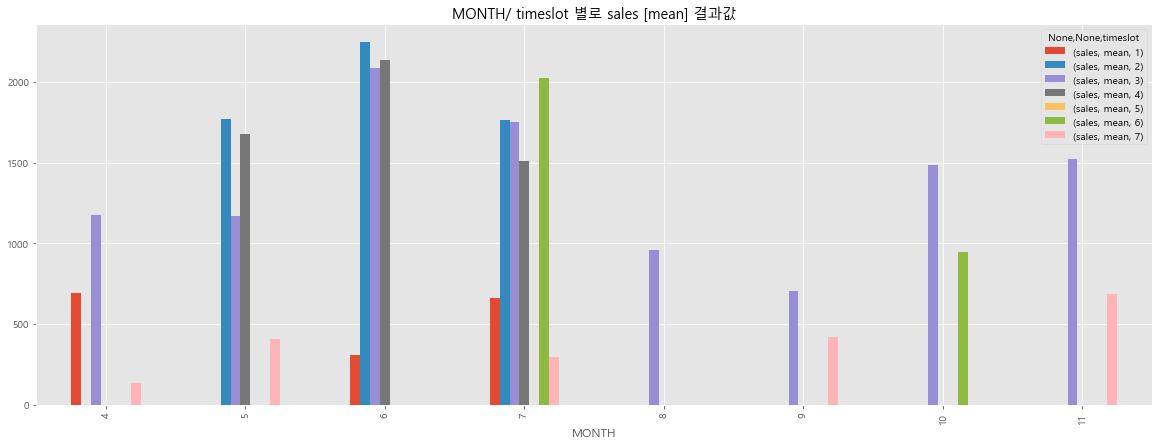

In [504]:
sum_df[sum_df.p_group=='침구'].groupby(['MONTH','timeslot']).agg({'sales':['mean']}).unstack().plot(kind='bar', figsize=(20,7))
plt.title('MONTH/ timeslot 별로 sales [mean] 결과값')

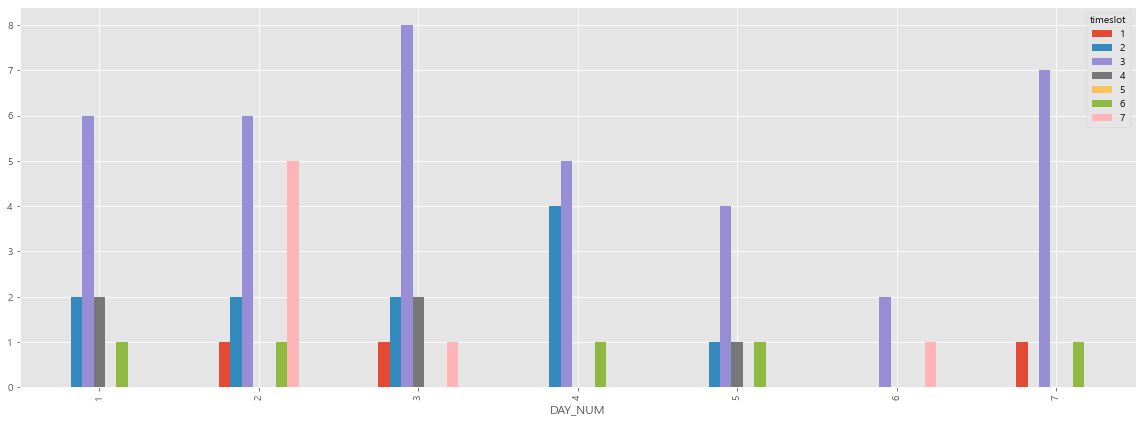

In [507]:
# 침구관련된 
sum_df[sum_df.p_group=='침구'].groupby(['DAY_NUM','timeslot']).size().unstack().plot(kind='bar', figsize=(20,7))

In [567]:
cg_df = sum_df[sum_df.p_group=='침구'][['broadcast','MONTH','timeslot','p_code','m_code','p_name','sales','no']]
cg_df[['p_code','m_code','no']].sort_values


cg_df.groupby(['m_code','p_code','p_name'])

In [568]:
cg_df['p_name'].unique()

array(['보몽드 순면60수 피그먼트워싱 침구세트 SS', '(일)[한샘] 호텔식 레일 암막커튼 세트(중형)',
       '리앤코리아 순면 볼륨 카페트 세트(중형)', '효재 자수 광목 워싱 침구세트 슈퍼싱글',
       '보몽드 샐비어 시어서커 리플 침구세트 SS', '보몽드 엘사 자수 쿨 시어서커 침구세트 SS', '안지 청풍 대자리',
       '효재 화원 자수 광목워싱 침구세트 킹', '보몽드 엘리 소프트플란넬 침구세트 SK(슈퍼킹)',
       '보몽드 클라라 소프트플란넬 침구세트 SK(슈퍼킹)', '효재 동백 자수 광목 워싱차렵침구세트K',
       '한빛 페르시안스타일 셔닐 카페트 점보특대형', '리앤 헤링본 러그 카페트 점보특대형',
       '보몽드 헤르만 착번아웃 극세사 침구세트 SK(슈퍼킹)', '보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹)'],
      dtype=object)

In [578]:
len(sum_df[sum_df.p_group=='의류']['p_name'].unique())

204

In [582]:
sum_df[sum_df.p_group=='침구']['p_name'].unique()

array(['보몽드 순면60수 피그먼트워싱 침구세트 SS', '(일)[한샘] 호텔식 레일 암막커튼 세트(중형)',
       '리앤코리아 순면 볼륨 카페트 세트(중형)', '효재 자수 광목 워싱 침구세트 슈퍼싱글',
       '보몽드 샐비어 시어서커 리플 침구세트 SS', '보몽드 엘사 자수 쿨 시어서커 침구세트 SS', '안지 청풍 대자리',
       '효재 화원 자수 광목워싱 침구세트 킹', '보몽드 엘리 소프트플란넬 침구세트 SK(슈퍼킹)',
       '보몽드 클라라 소프트플란넬 침구세트 SK(슈퍼킹)', '효재 동백 자수 광목 워싱차렵침구세트K',
       '한빛 페르시안스타일 셔닐 카페트 점보특대형', '리앤 헤링본 러그 카페트 점보특대형',
       '보몽드 헤르만 착번아웃 극세사 침구세트 SK(슈퍼킹)', '보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹)'],
      dtype=object)

In [155]:
cg_df= sum_df[sum_df.p_group=='침구']
cg_list = ['침구세트','암막커튼','카페트','대자리']

In [314]:
cg_df[cg_df['p_group']=='침구']

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season,holiday,group_detail
2122,2019-04-18 12:00:00,60.000000,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,83998000.0,1215.0,2019,...,11,2242.0,11075,c,3,2,3,1,0,침구세트
2216,2019-04-23 13:00:00,60.000000,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,79811000.0,1134.0,2019,...,11,2354.0,11638,c,3,2,3,1,0,침구세트
2227,2019-04-23 01:00:00,55.066667,100503,201541,(일)[한샘] 호텔식 레일 암막커튼 세트(중형),침구,159000,25176000.0,133.0,2019,...,11,2355.0,11725,a,4,2,7,1,0,암막커튼
2228,2019-04-24 06:00:00,60.000000,100112,200309,리앤코리아 순면 볼륨 카페트 세트(중형),침구,49900,43304000.0,693.0,2019,...,11,2375.0,11749,b,4,2,1,1,0,카페트
2406,2019-05-03 13:00:00,60.000000,100200,200675,효재 자수 광목 워싱 침구세트 슈퍼싱글,침구,129000,97161000.0,638.0,2019,...,11,2562.0,12743,b,3,2,3,1,0,침구세트
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6060,2019-11-11 14:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,96350000.0,1325.0,2019,...,11,6866.0,33271,c,3,4,3,3,0,침구세트
6096,2019-11-13 13:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,108818000.0,1511.0,2019,...,11,6943.0,33453,c,3,4,3,3,0,침구세트
6203,2019-11-19 13:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,110848000.0,1526.0,2019,...,11,7164.0,34030,c,3,4,3,3,0,침구세트
6242,2019-11-21 12:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,122006000.0,1638.0,2019,...,11,7239.0,34239,d,3,4,3,3,0,침구세트


In [315]:
cg_df[cg_df['p_name'].str.contains('침구세트')][['unit_price','sales','MONTH','no']]

,unit_price,sales,MONTH,no
2122,59900,1215.0,4,11075
2216,59900,1134.0,4,11638
2406,129000,638.0,5,12743
2492,59900,409.0,5,13370
2677,49900,2044.0,5,14546
...,...,...,...,...
6060,59900,1325.0,11,33271
6096,59900,1511.0,11,33453
6203,59900,1526.0,11,34030
6242,59900,1638.0,11,34239


In [328]:
cg_df[cg_df['p_name'].str.contains('침구세트')][['broadcast','unit_price','sales','MONTH','no']].sort_values('sales', ascending=False)

,broadcast,unit_price,sales,MONTH,no
2980,2019-06-02 13:00:00,49900,3695.0,6,16260
3525,2019-06-30 12:00:00,59900,2940.0,6,19109
3313,2019-06-19 15:00:00,49900,2490.0,6,18079
3645,2019-07-06 14:00:00,59900,2461.0,7,19761
3175,2019-06-12 11:00:00,49900,2432.0,6,17332
...,...,...,...,...,...
5055,2019-09-17 01:00:00,49900,459.0,9,27597
2492,2019-05-07 01:00:00,59900,409.0,5,13370
3152,2019-06-11 08:00:00,129000,309.0,6,17202
3986,2019-07-23 01:00:00,139000,295.0,7,21764


In [95]:
cg_df[cg_df['p_name'].str.contains('암막커튼')][['unit_price','sales','MONTH','no']]

,unit_price,sales,MONTH,no
2227,159000,133.0,4,11725


In [316]:
cg_df[cg_df['p_name'].str.contains('대자리')][['broadcast','unit_price','sales','MONTH','no']]

,broadcast,unit_price,sales,MONTH,no
3779,2019-07-13 14:00:00,50900,2384.0,7,20520
3875,2019-07-18 12:00:00,50900,1523.0,7,21109
4264,2019-08-07 14:00:00,50900,1456.0,8,23264


In [97]:
cg_df[cg_df['p_name'].str.contains('카페트')][['unit_price','sales','MONTH','no']]

,unit_price,sales,MONTH,no
2228,49900,693.0,4,11749
5704,69000,1068.0,10,31348
5742,49900,630.0,10,31569
5811,69000,1140.0,10,31912


In [118]:
#1분당 판매 갯수 구하기
cg_df['slaes/minutes'] = round(cg_df['sales']/cg_df['exp_min'],2)
cg_df

C:\Users\johc5\.conda\envs\multi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season,holiday,slaes/minutes
2122,2019-04-18 12:00:00,60.000000,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,83998000.0,1215.0,2019,...,11,2242.0,11075,c,3,2,3,1,0,20.25
2216,2019-04-23 13:00:00,60.000000,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,79811000.0,1134.0,2019,...,11,2354.0,11638,c,3,2,3,1,0,18.90
2227,2019-04-23 01:00:00,55.066667,100503,201541,(일)[한샘] 호텔식 레일 암막커튼 세트(중형),침구,159000,25176000.0,133.0,2019,...,11,2355.0,11725,a,4,2,7,1,0,2.42
2228,2019-04-24 06:00:00,60.000000,100112,200309,리앤코리아 순면 볼륨 카페트 세트(중형),침구,49900,43304000.0,693.0,2019,...,11,2375.0,11749,b,4,2,1,1,0,11.55
2406,2019-05-03 13:00:00,60.000000,100200,200675,효재 자수 광목 워싱 침구세트 슈퍼싱글,침구,129000,97161000.0,638.0,2019,...,11,2562.0,12743,b,3,2,3,1,0,10.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6060,2019-11-11 14:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,96350000.0,1325.0,2019,...,11,6866.0,33271,c,3,4,3,3,0,22.08
6096,2019-11-13 13:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,108818000.0,1511.0,2019,...,11,6943.0,33453,c,3,4,3,3,0,25.18
6203,2019-11-19 13:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,110848000.0,1526.0,2019,...,11,7164.0,34030,c,3,4,3,3,0,25.43
6242,2019-11-21 12:20:00,60.000000,100143,200396,보몽드 카밀라 더블착번극세사 토퍼침구세트 SK(슈퍼킹),침구,59900,122006000.0,1638.0,2019,...,11,7239.0,34239,d,3,4,3,3,0,27.30


In [250]:
cg_df['detail1'] = cg_df['p_name'].str.contains('침구세트').map({True:'침구세트',False:''})

cg_df['detail2'] = cg_df['p_name'].str.contains('암막커튼').map({True:'암막커튼',False:''})
cg_df['detail3'] = cg_df['p_name'].str.contains('카페트').map({True:'카페트',False:''})
cg_df['detail4'] = cg_df['p_name'].str.contains('대자리').map({True:'대자리',False:''})

cg_df['group_detail'] = cg_df[['detail1', 'detail2', 'detail3', 'detail4']].apply(lambda x: ''.join(x), axis=1)

del cg_df['detail1'], cg_df['detail2'], cg_df['detail3'], cg_df['detail4']


C:\Users\johc5\.conda\envs\multi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\johc5\.conda\envs\multi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\johc5\.conda\envs\multi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

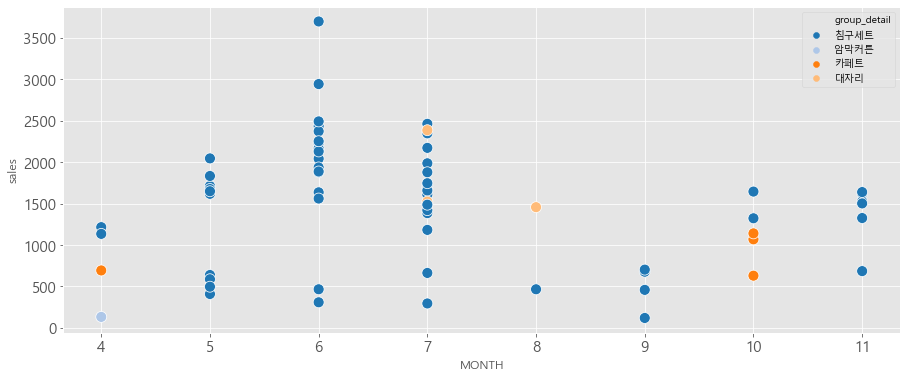

In [295]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='MONTH', y='sales', hue='group_detail', s=120, data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

plt.show()

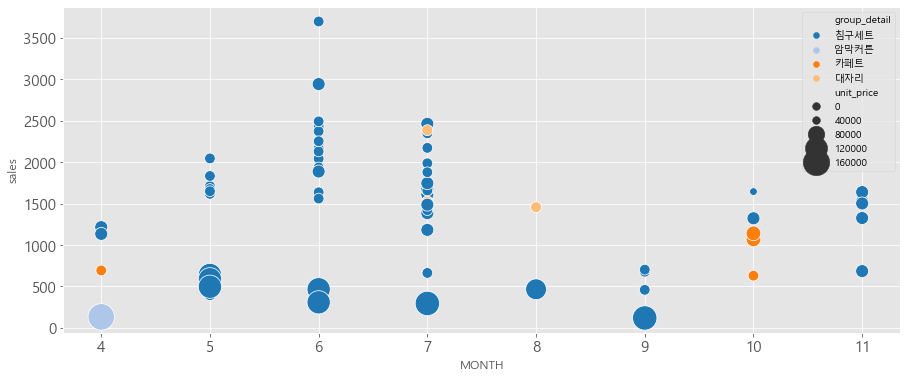

In [306]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='MONTH', y='sales', hue='group_detail', size='unit_price', sizes=(60,700),data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

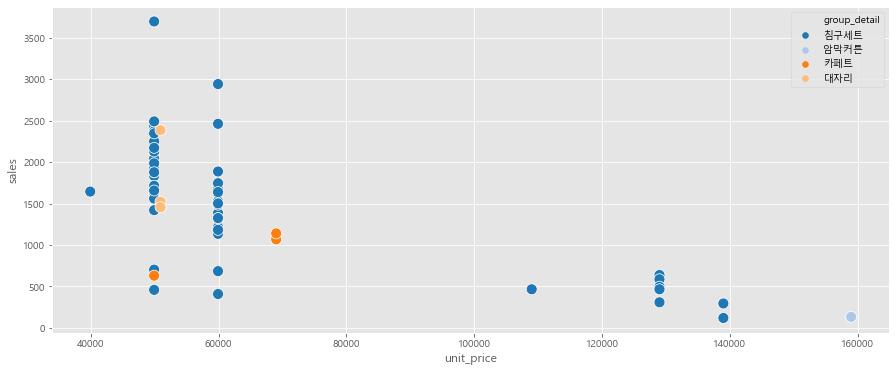

In [365]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='unit_price', y='sales', hue='group_detail',data=cg_df, palette='tab20',s=120)
plt.show()

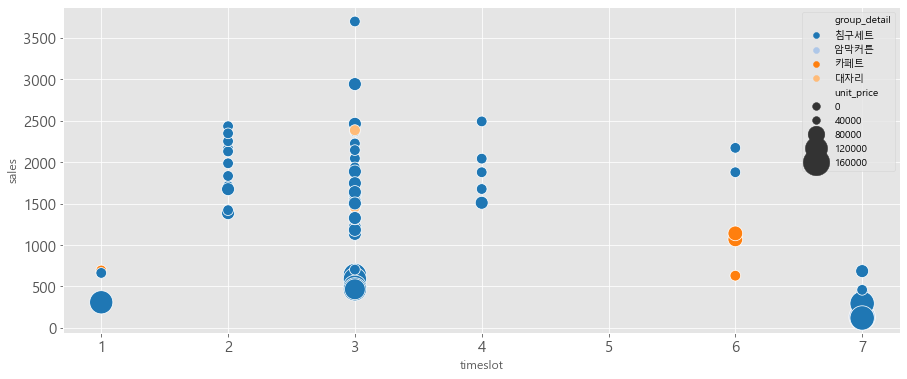

In [308]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='timeslot', y='sales', hue='group_detail', size='unit_price', sizes=(60,700),data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

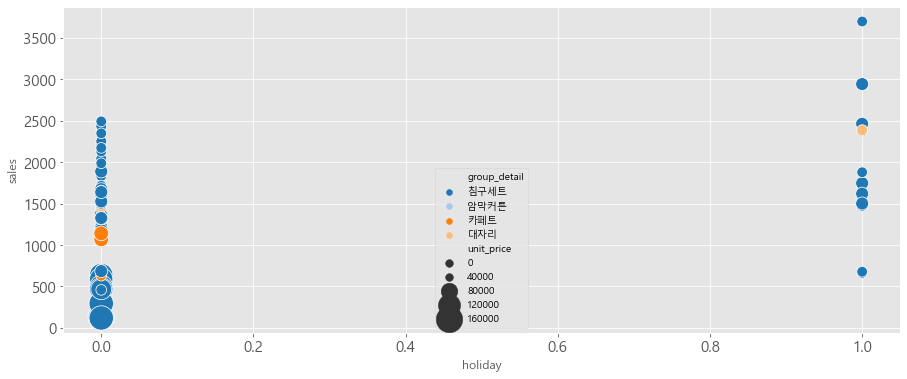

In [309]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='holiday', y='sales', hue='group_detail', size='unit_price', sizes=(60,700),data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

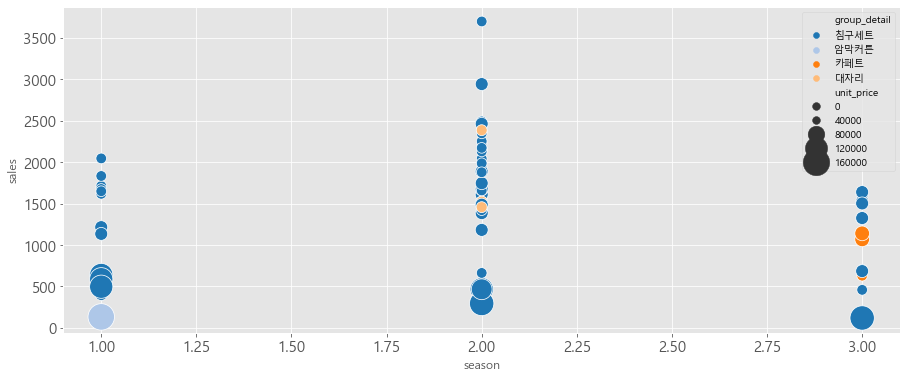

In [310]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='season', y='sales', hue='group_detail', size='unit_price', sizes=(60,700),data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

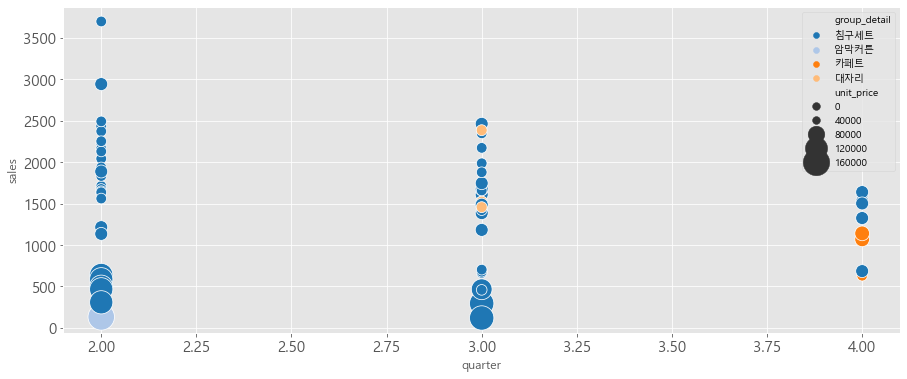

In [311]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='quarter', y='sales', hue='group_detail', size='unit_price', sizes=(60,700),data=cg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

## 가전

In [330]:
gj_df = sum_df[sum_df.p_group=='가전']
gj_df['p_name'].unique()

array(['일시불 LG 통돌이 세탁기', '일시불 LG전자 매직스페이스 냉장고',
       '일시불 LG 울트라HD TV 55UK6800HNC', '일시불 삼성 노트북 9 메탈 기본형 NT900X5J-K14',
       '일시불 삼성 UHD TV UN55NU7010FXKR',
       '일시불 삼성 블루스카이 공기청정기 AX40N3080DMD 1세트',
       '일시불 삼성 건조기 9kg 블랙케비어 DV90M53B0QV', '일시불 대우전자 미니건조기 DWR-03IDDC',
       '일시불 삼성 유로피안 냉장고RS82M6000S8', '일시불 LG 노트북 그램 15인치 15Z980-L.AR1DK',
       '일시불 삼성 UHD 국민TV UN55NU7010FXKR', '일시불 LG 퓨리케어 공기청정기 AS281DAW',
       '일시불 LG 코드제로 무선청소기 A950 (A958IA) 더블팩',
       '일시불 LG 휘센 에어컨 위너 FQ17V8WWJ2(2in1)',
       '일시불 삼성 블루스카이 공기청정기 7000 AX80R7580WDD',
       '일시불 삼성 무풍슬림 홈멀티  에어컨  AF16R5773WSR', '일시불 삼성 UHD TV UN55NU7050F',
       '일시불 삼성 5도어 냉장고 H9000 RH81M8011S9',
       '일시불 삼성 엑티브워시 세탁기14kg WA14N6781TG', '일시불 LG스타일러 의류관리기  (5벌)S5BB',
       '일시불 LG 휘센 씽큐 에어컨 2IN1형 FQ17V9KWA2', '일시불 대우전자 벽걸이 에어컨 DOZ-S06JK',
       '일시불 캐리어 벽걸이에어컨 6형 ARC06NQT', '일시불 LG전자 휴대용 퓨리케어 미니 공청기',
       '일시불 삼성 무풍클래식 홈멀티에어컨 AF17R7573WZR',
       '일시불 LG전자 노크온 매직스페이스 냉장고 S831SN75',
       '일시불 삼성 4도어 푸드쇼케이

In [331]:
gj_list =['세탁기','냉장고','TV','노트북','공기청정기','건조기','청소기','에어컨','의류관리기','공청기','로보킹','청소기','김치냉장고']

In [353]:
gj_df['detail1'] = gj_df['p_name'].str.contains('김치냉장고').map({True:'김치냉장고',False:''})
gj_df.loc[gj_df.detail1=='김치냉장고',:]
# gj_df['detail1'] = gj_df['p_name'].str.contains('냉장고').map({True:'냉장고',False:''})
gj_df.loc[gj_df.detail1=='김치냉장고',:]


C:\Users\johc5\.conda\envs\multi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season,holiday,detail1
4930,2019-09-11 12:00:00,60.0,100091,200253,467L_딤채김치냉장고,가전,2599000,72515000.0,27.0,2019,...,5,5378.0,26860,a,3,3,3,3,0,김치냉장고
5087,2019-09-19 19:00:00,60.0,100091,200253,467L_딤채김치냉장고,가전,2599000,80352000.0,31.0,2019,...,5,5545.0,27793,a,3,3,5,3,0,김치냉장고
5321,2019-10-02 11:00:00,60.0,100091,200253,467L_딤채김치냉장고,가전,2599000,102147000.0,39.0,2019,...,5,5819.0,29156,a,3,4,2,3,0,김치냉장고
5847,2019-10-30 22:00:00,60.0,100091,200252,221L_딤채김치냉장고,가전,899000,162184000.0,181.0,2019,...,5,6405.0,32100,a,3,4,6,3,0,김치냉장고
5908,2019-11-03 09:20:00,60.0,100091,200250,(1등급)467L_딤채김치냉장고,가전,899000,148453000.0,74.0,2019,...,5,6525.0,32423,a,3,4,2,3,1,김치냉장고
5997,2019-11-07 22:20:00,60.0,100091,200250,(1등급)467L_딤채김치냉장고,가전,899000,121252000.0,73.0,2019,...,5,6679.0,32917,a,3,4,6,3,0,김치냉장고
6025,2019-11-09 13:20:00,60.0,100091,200248,(1등급)221L_딤채김치냉장고,가전,899000,157360000.0,174.0,2019,...,5,6756.0,33086,a,3,4,3,3,1,김치냉장고
6031,2019-11-09 21:20:00,60.0,100091,200250,(1등급)467L_딤채김치냉장고,가전,899000,127924000.0,80.0,2019,...,5,6758.0,33109,a,3,4,6,3,1,김치냉장고
6045,2019-11-10 17:20:00,60.0,100091,200250,(1등급)467L_딤채김치냉장고,가전,899000,104293000.0,64.0,2019,...,5,6795.0,33179,a,3,4,4,3,1,김치냉장고
6067,2019-11-11 21:20:00,60.0,100091,200250,(1등급)467L_딤채김치냉장고,가전,899000,158396000.0,95.0,2019,...,5,6832.0,33301,a,3,4,6,3,0,김치냉장고


In [ ]:


cg_df['detail1'] = cg_df['p_name'].str.contains('침구세트').map({True:'침구세트',False:''})

cg_df['detail2'] = cg_df['p_name'].str.contains('암막커튼').map({True:'암막커튼',False:''})
cg_df['detail3'] = cg_df['p_name'].str.contains('카페트').map({True:'카페트',False:''})
cg_df['detail4'] = cg_df['p_name'].str.contains('대자리').map({True:'대자리',False:''})

cg_df['group_detail'] = cg_df[['detail1', 'detail2', 'detail3', 'detail4']].apply(lambda x: ''.join(x), axis=1)

del cg_df['detail1'], cg_df['detail2'], cg_df['detail3'], cg_df['detail4']


# 가구

In [357]:
gg_df = sum_df[sum_df.p_group=='가구']
gg_df

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NUM,p_group_code,new_code,no,sales_level,grade,quarter,timeslot,season,holiday
634,2019-02-01 22:00:00,60.0,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,169247000.0,285.0,2019,...,5,10,621.0,2952,a,2,1,6,4,0
692,2019-02-04 20:00:00,60.0,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,150677000.0,254.0,2019,...,1,10,681.0,3231,a,3,1,5,4,1
734,2019-02-06 23:00:00,60.0,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,178832000.0,304.0,2019,...,3,10,721.0,3486,a,2,1,6,4,1
772,2019-02-08 21:00:00,60.0,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,217876000.0,372.0,2019,...,5,10,761.0,3681,a,2,1,6,4,0
854,2019-02-12 23:00:00,60.0,100500,201510,(일) 삼익가구 LED 제니비 서랍형 침대 SS,가구,499000,164505000.0,293.0,2019,...,2,10,841.0,4062,a,3,1,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6668,2019-12-15 07:20:00,60.0,100373,201196,(일)장수흙침대 싱글,가구,1120000,165961000.0,124.0,2019,...,7,10,8107.0,36685,a,3,4,1,4,1
6736,2019-12-18 23:20:00,60.0,100373,201196,(일)장수흙침대 싱글,가구,1120000,131841000.0,95.0,2019,...,3,10,8224.0,37094,a,3,4,6,4,0
6773,2019-12-20 22:20:00,60.0,100373,201196,(일)장수흙침대 싱글,가구,1120000,200354000.0,145.0,2019,...,5,10,8300.0,37279,a,2,4,6,4,0
6825,2019-12-23 23:20:00,60.0,100373,201196,(일)장수흙침대 싱글,가구,1120000,176344000.0,130.0,2019,...,1,10,8416.0,37559,a,2,4,6,4,0


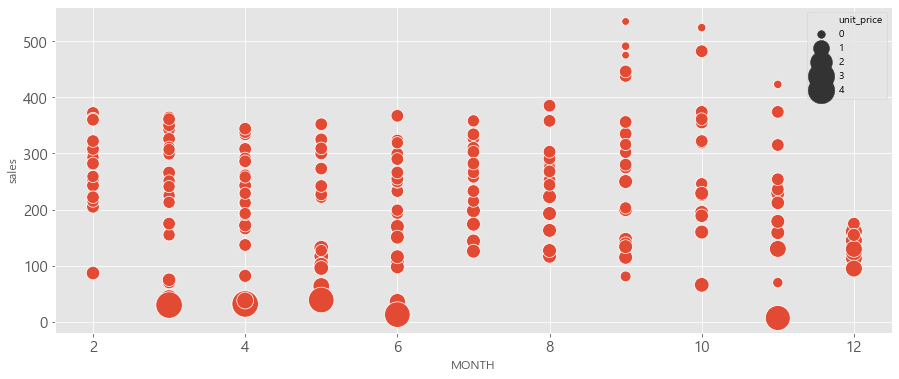

In [359]:
gg_df = sum_df[sum_df.p_group=='가구']
gg_df

plt.figure(figsize=(15,6))
sns.scatterplot(x='MONTH', y='sales', size='unit_price', sizes=(60,700),data=gg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

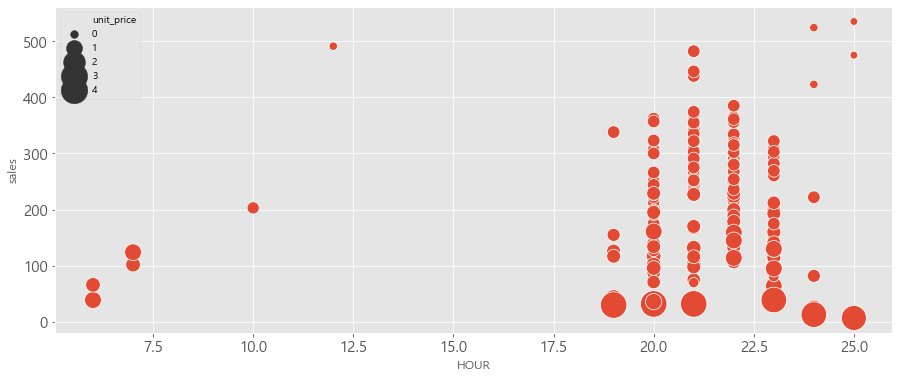

In [361]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='HOUR', y='sales', size='unit_price', sizes=(60,700),data=gg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

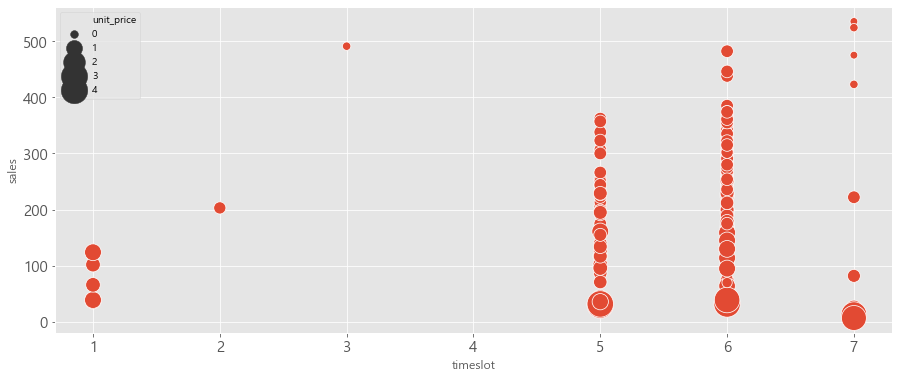

In [360]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='timeslot', y='sales', size='unit_price', sizes=(60,700),data=gg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='MONTH', y='sales', size='unit_price', sizes=(60,700),data=gg_df, palette='tab20')
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

In [ ]:
# 가전

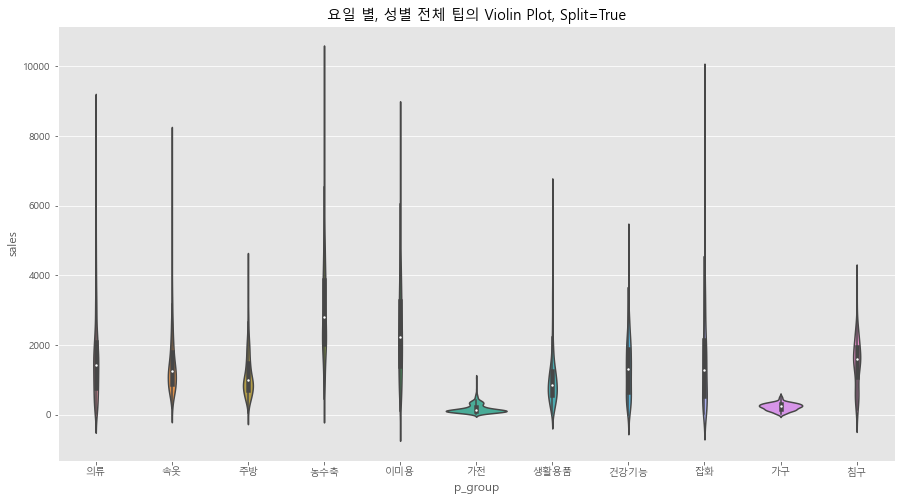

In [448]:
plt.figure(figsize=(15,8))
sns.violinplot(x="p_group", y='sales', data=sum_df, hue='' split=True)

plt.title("요일 별, 성별 전체 팁의 Violin Plot, Split=True")
plt.show()

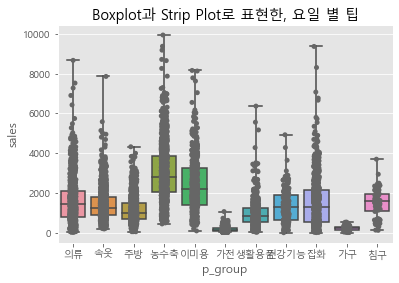

In [438]:
plt.title("Boxplot과 Strip Plot로 표현한, 요일 별 팁")
sns.boxplot(x="p_group", y="sales", data=sum_df, whis=np.inf)
sns.stripplot(x="p_group", y="sales", data=sum_df, jitter=True, color="0.4")
plt.show()

In [454]:
import matplotlib.pyplot as plt
import math

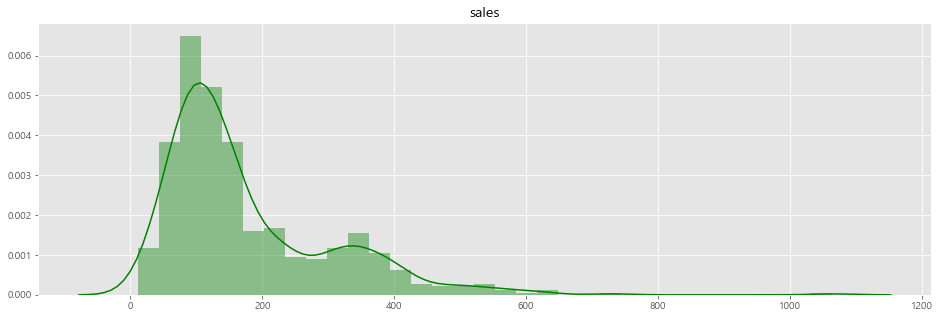

In [467]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='가전']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


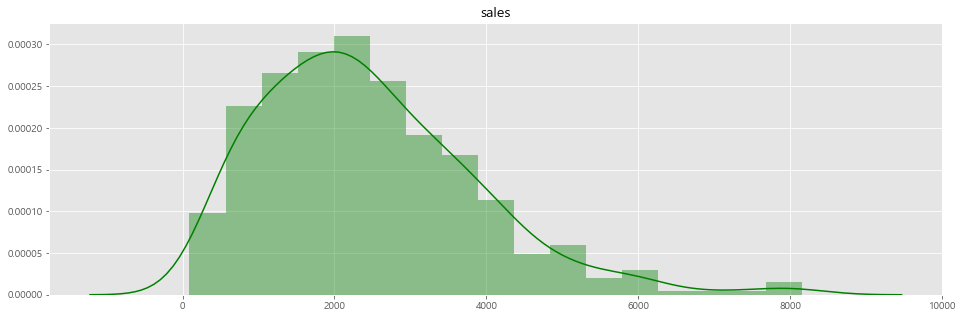

In [468]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='이미용']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


C:\Users\johc5\.conda\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

C:\Users\johc5\.conda\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



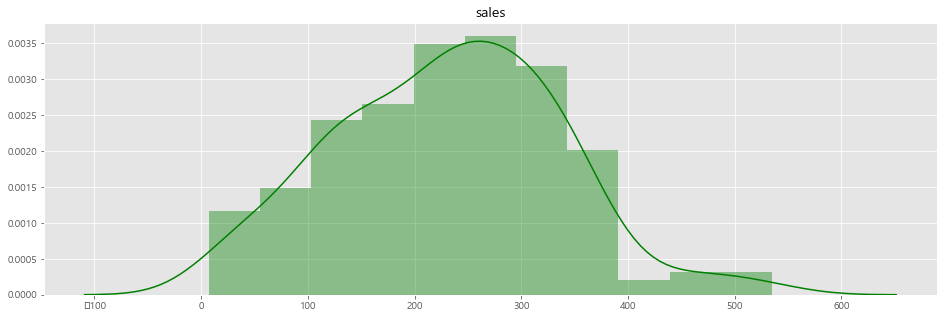

In [469]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='가구']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


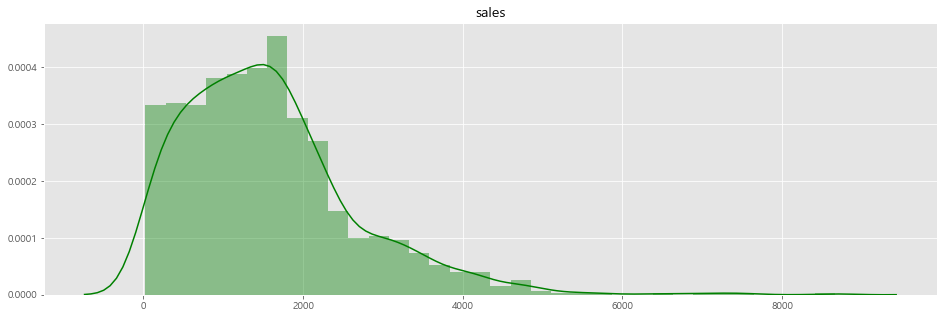

In [470]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='의류']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


C:\Users\johc5\.conda\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

C:\Users\johc5\.conda\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



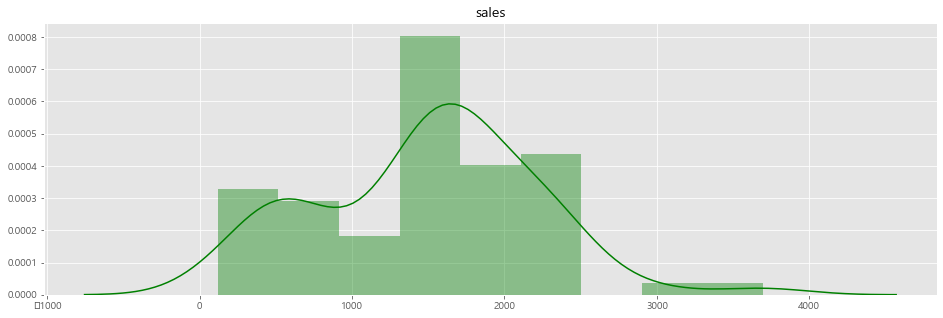

In [471]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='침구']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


In [ ]:
# 대출 금액 plot
fig, ax = plt.subplots(1, 1, figsize=(16,5))
sales = sum_df[sum_df.p_group=='이미용']["sales"].values
sns.distplot(sales, ax=ax, color='green')
ax.set_title("sales", fontsize=14)
plt.show()


# EDA 주방, 가전, 생활용품

## EDA_주방

In [79]:
jb_df = sum_df[sum_df.p_group=='주방']
temp_df = pd.qcut(jb_df[jb_df['p_group']=='주방'].unit_price, q=5,
                  labels = ['a','b','c','d','e']).to_frame().rename(columns={'unit_price':'grade_by_group'})
temp_df

,grade_by_group
6,a
25,d
27,e
33,b
49,c
...,...
6953,b
6958,e
6961,b
6962,a


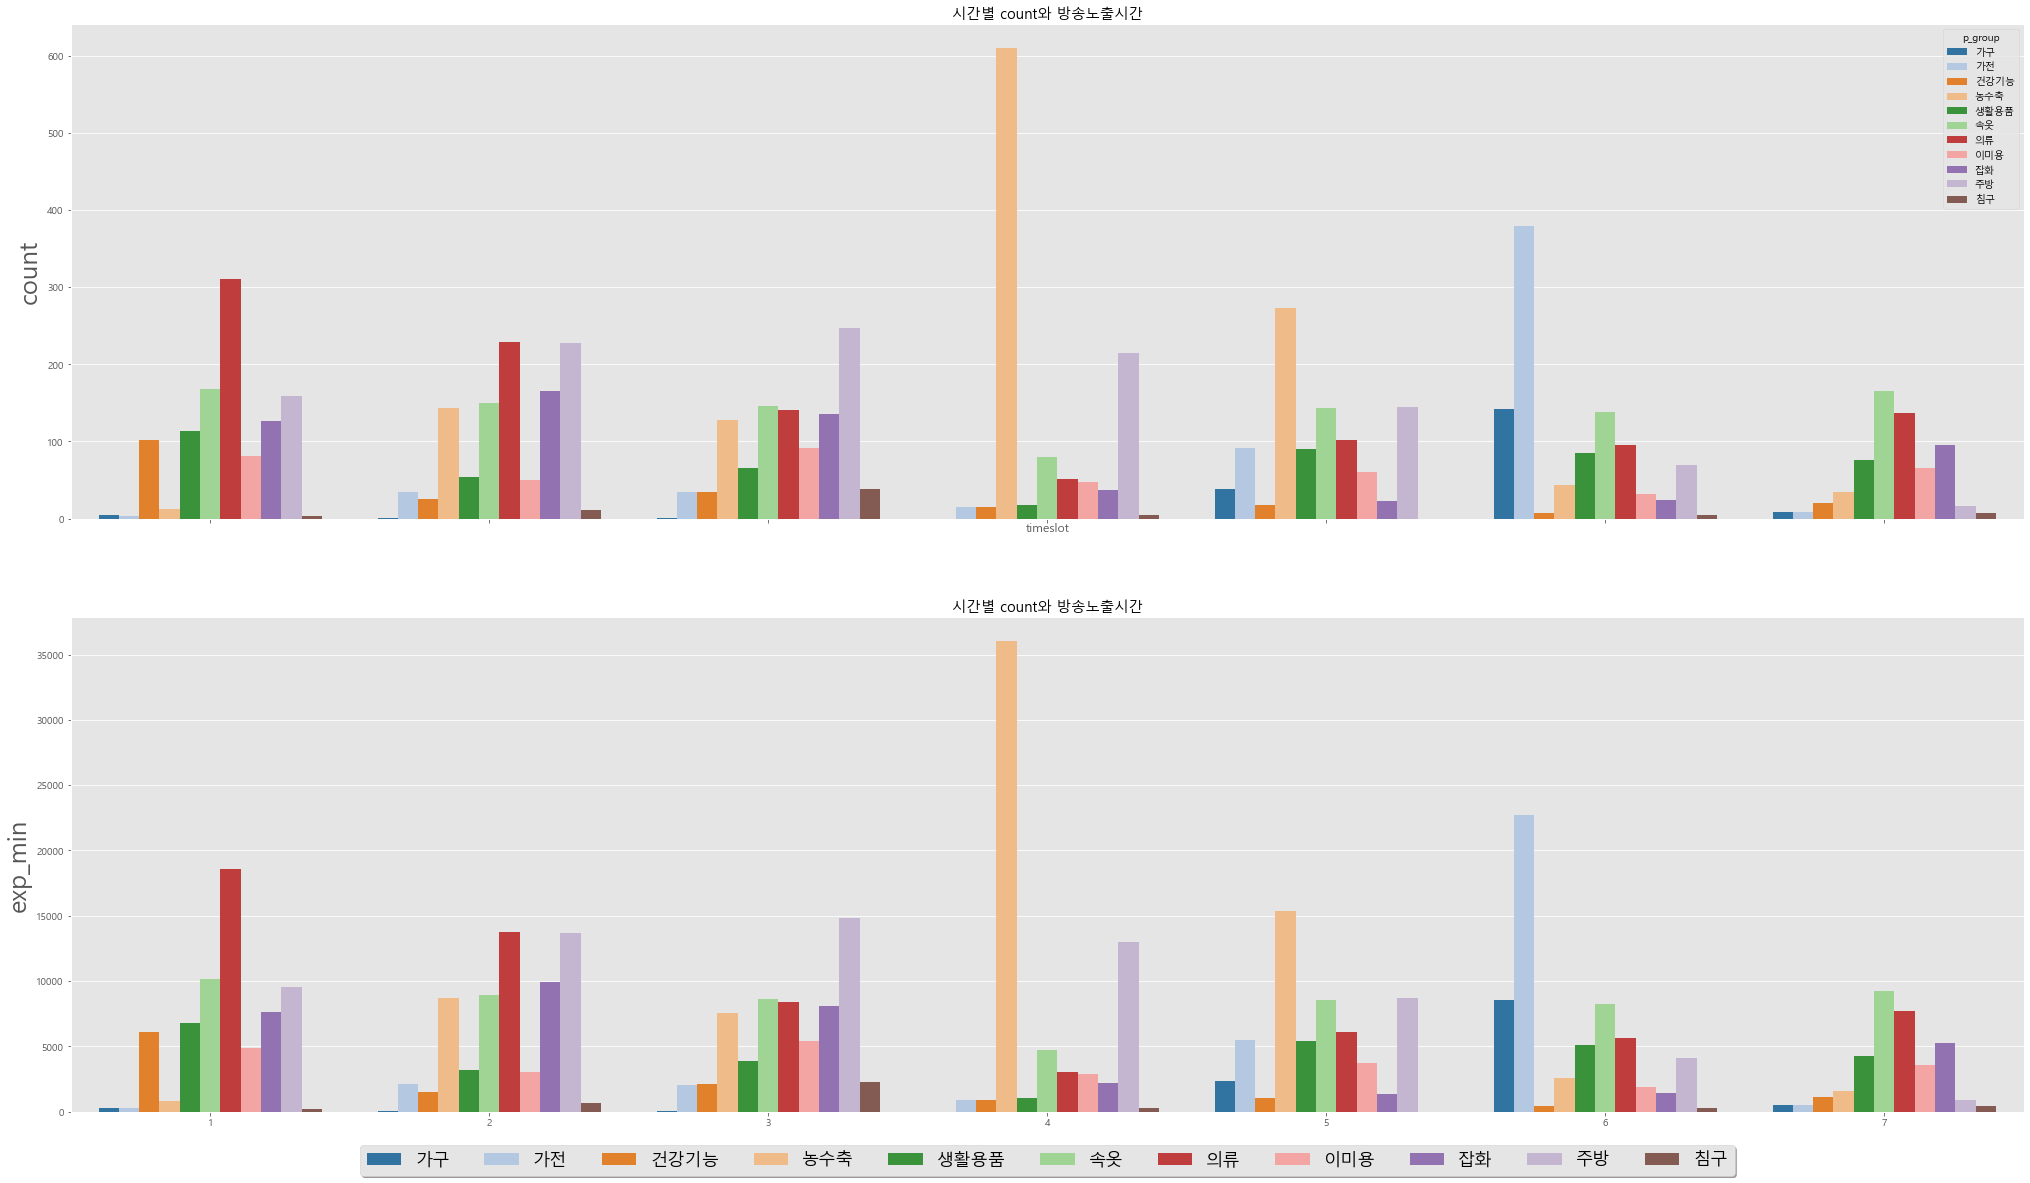

In [465]:
# timesolot별 방송count & 노출시간 합계
timeslot_cnt = sum_df.groupby(['timeslot','p_group']).agg({'unit_price':['count'], 'exp_min':['sum']})
timeslot_cnt.columns=['count', 'exp_min']
timeslot_cnt= timeslot_cnt.reset_index()

fig, axes = plt.subplots(2, 1, figsize=(35, 20), sharex=True)
for name, ax in zip(['count','exp_min'], axes):
    sns.barplot(data=timeslot_cnt, x='timeslot', y=name, hue='p_group',palette='tab20', ax=ax)
    ax.set_ylabel(name, fontsize=25)
    ax.set_title('시간별 count와 방송노출시간')

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-2]:
    ax.set_xlabel('')

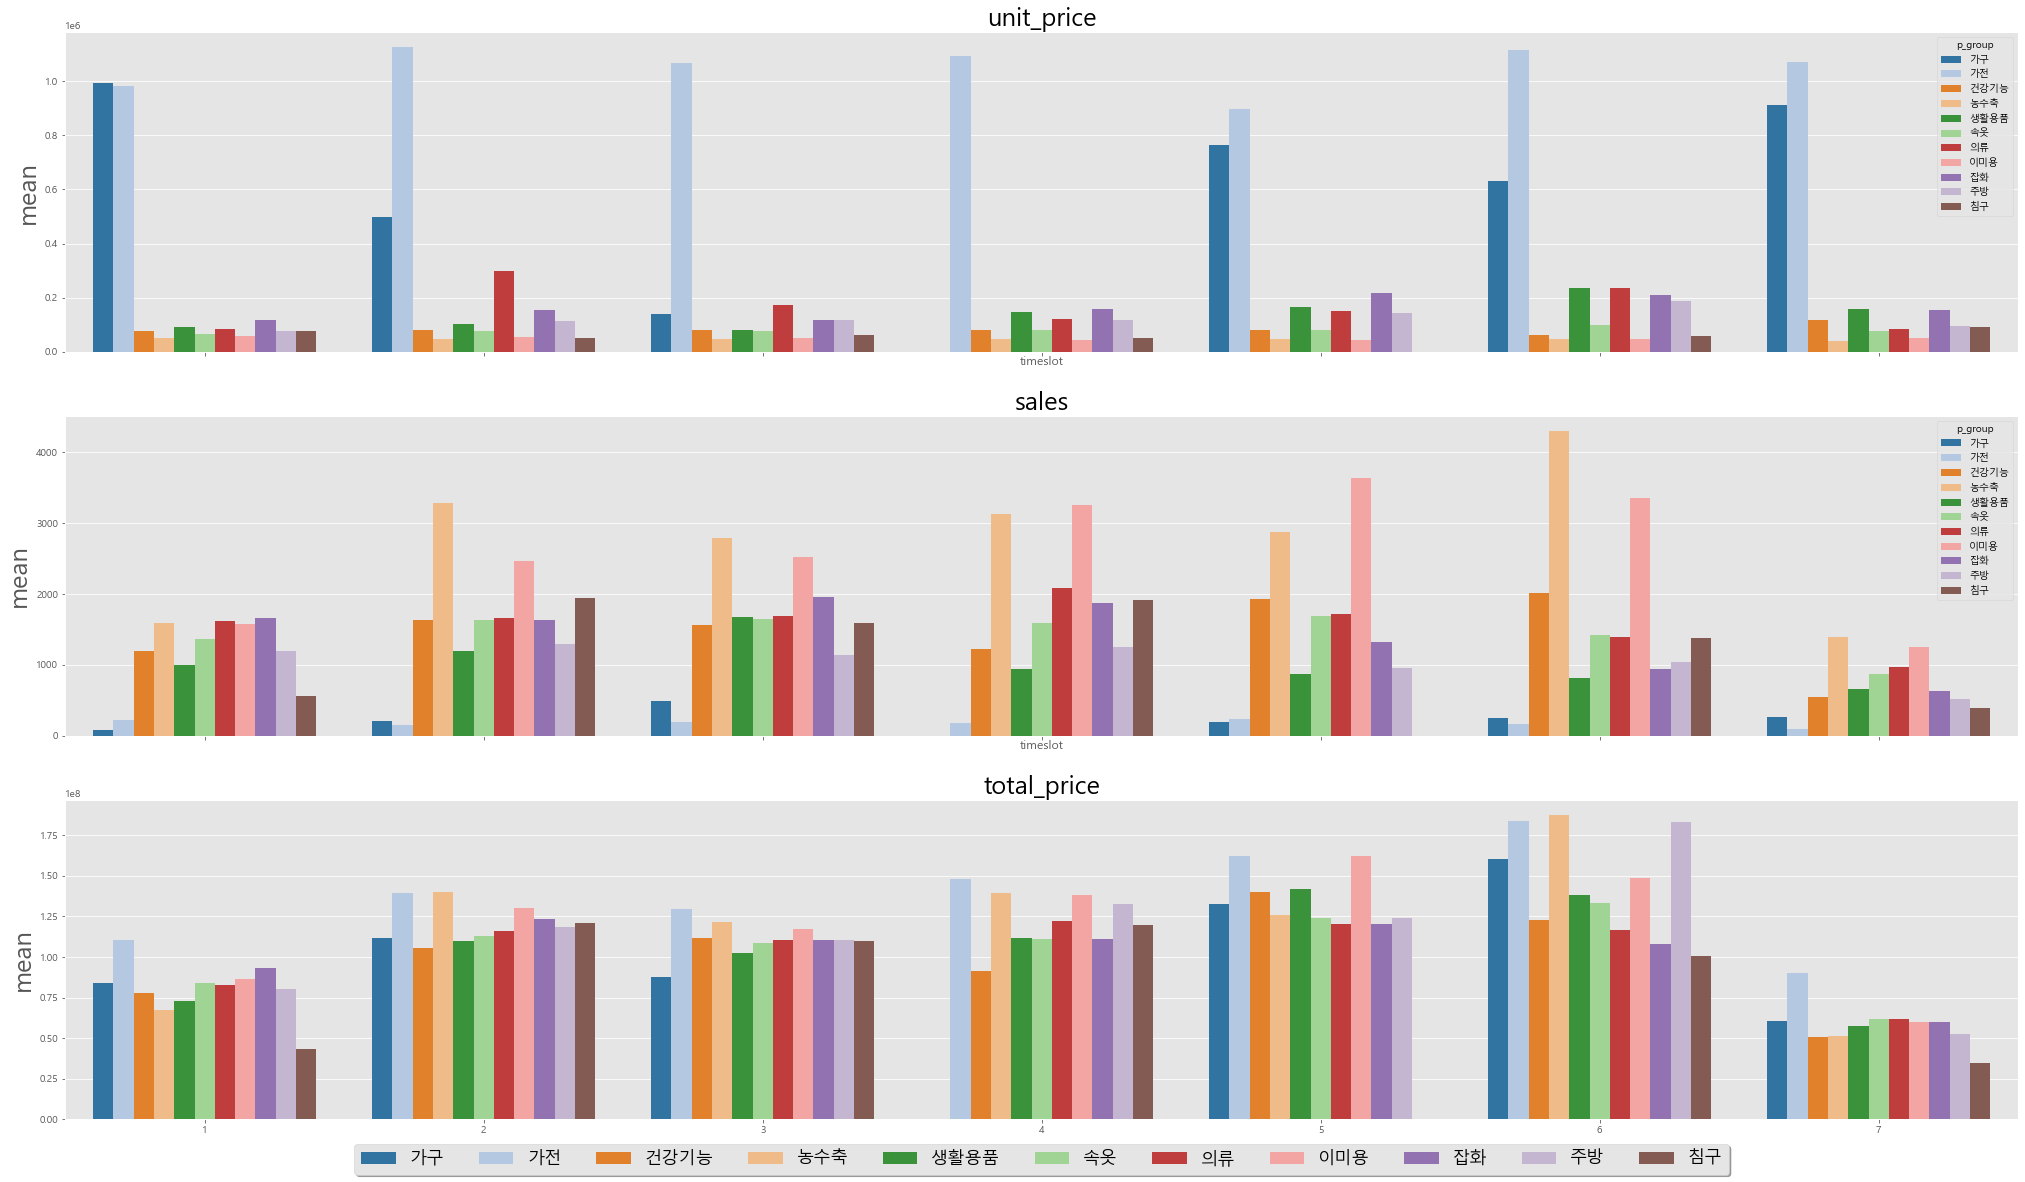

In [57]:
# timeslolt별로 unit_price / sales / total_price => mean
ts_mean= sum_df.groupby(['timeslot','p_group']).agg({'unit_price':['mean'], 'sales':['mean'],'total_price':['mean']})
ts_mean.columns=['unit_price','sales','total_price']
ts_mean=ts_mean.reset_index()

fig, axes = plt.subplots(3, 1, figsize=(35, 20), sharex=True)
for name, ax in zip(['unit_price', 'sales','total_price'], axes):
    sns.barplot(data=ts_mean, x='timeslot', y=name, hue='p_group',palette='tab20', ax=ax)
    ax.set_ylabel('mean', fontsize=25)
    ax.set_title(name, fontsize=25)

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-2]:
    ax.set_xlabel('')

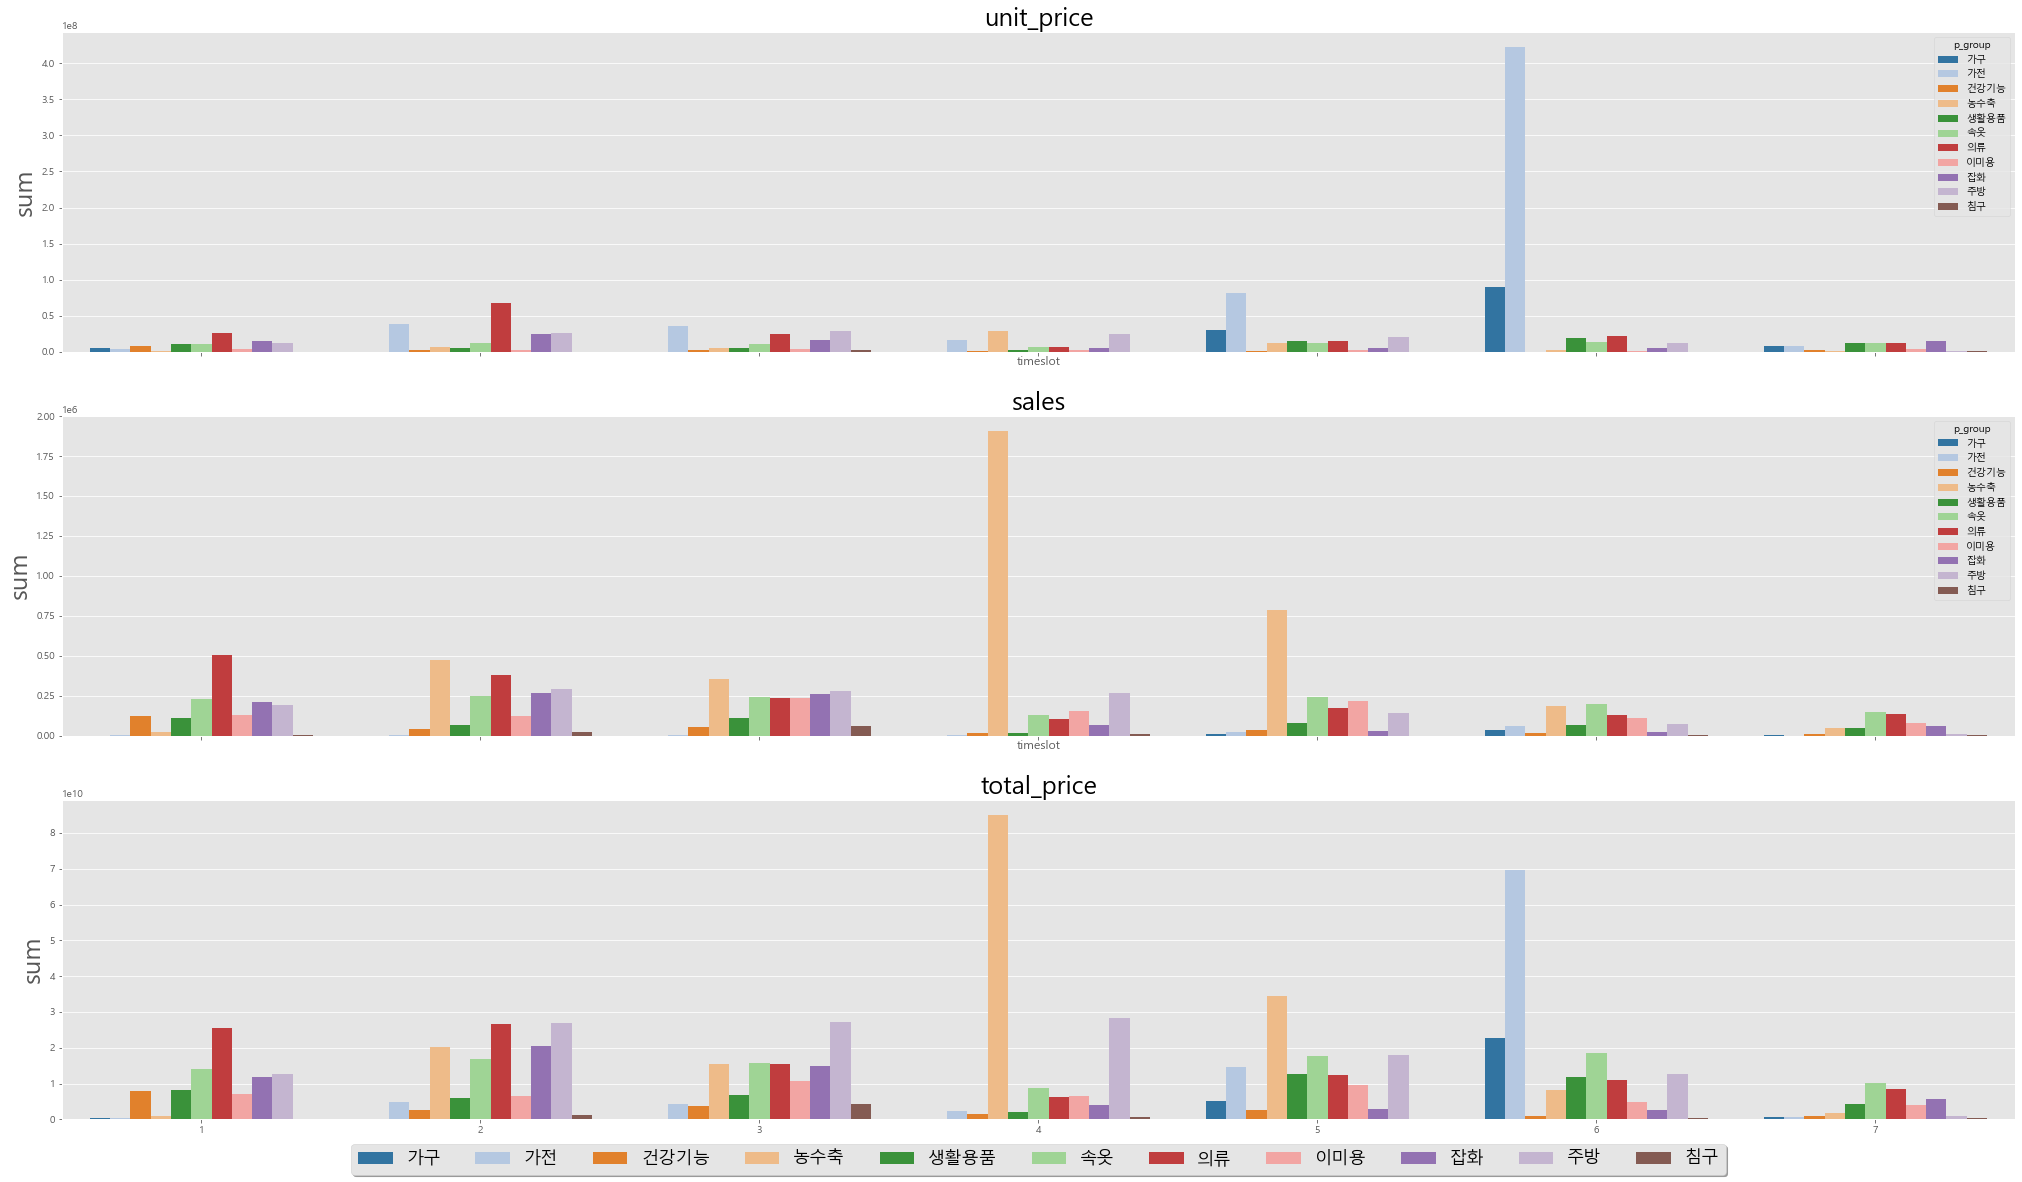

In [58]:
# timeslolt별로 unit_price / sales / total_price => sum
ts_sum = sum_df.groupby(['timeslot','p_group']).agg({'unit_price':['sum'], 'sales':['sum'],'total_price':['sum']})
ts_sum.columns=['unit_price','sales','total_price']
ts_sum =ts_sum .reset_index()

fig, axes = plt.subplots(3, 1, figsize=(35, 20), sharex=True)
for name, ax in zip(['unit_price', 'sales','total_price'], axes):
    sns.barplot(data=ts_sum, x='timeslot', y=name, hue='p_group',palette='tab20', ax=ax)
    ax.set_ylabel('sum', fontsize=25)
    ax.set_title(name, fontsize=25)

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-2]:
    ax.set_xlabel('')

### * 요일 -> 시간대별 -> 상품군별

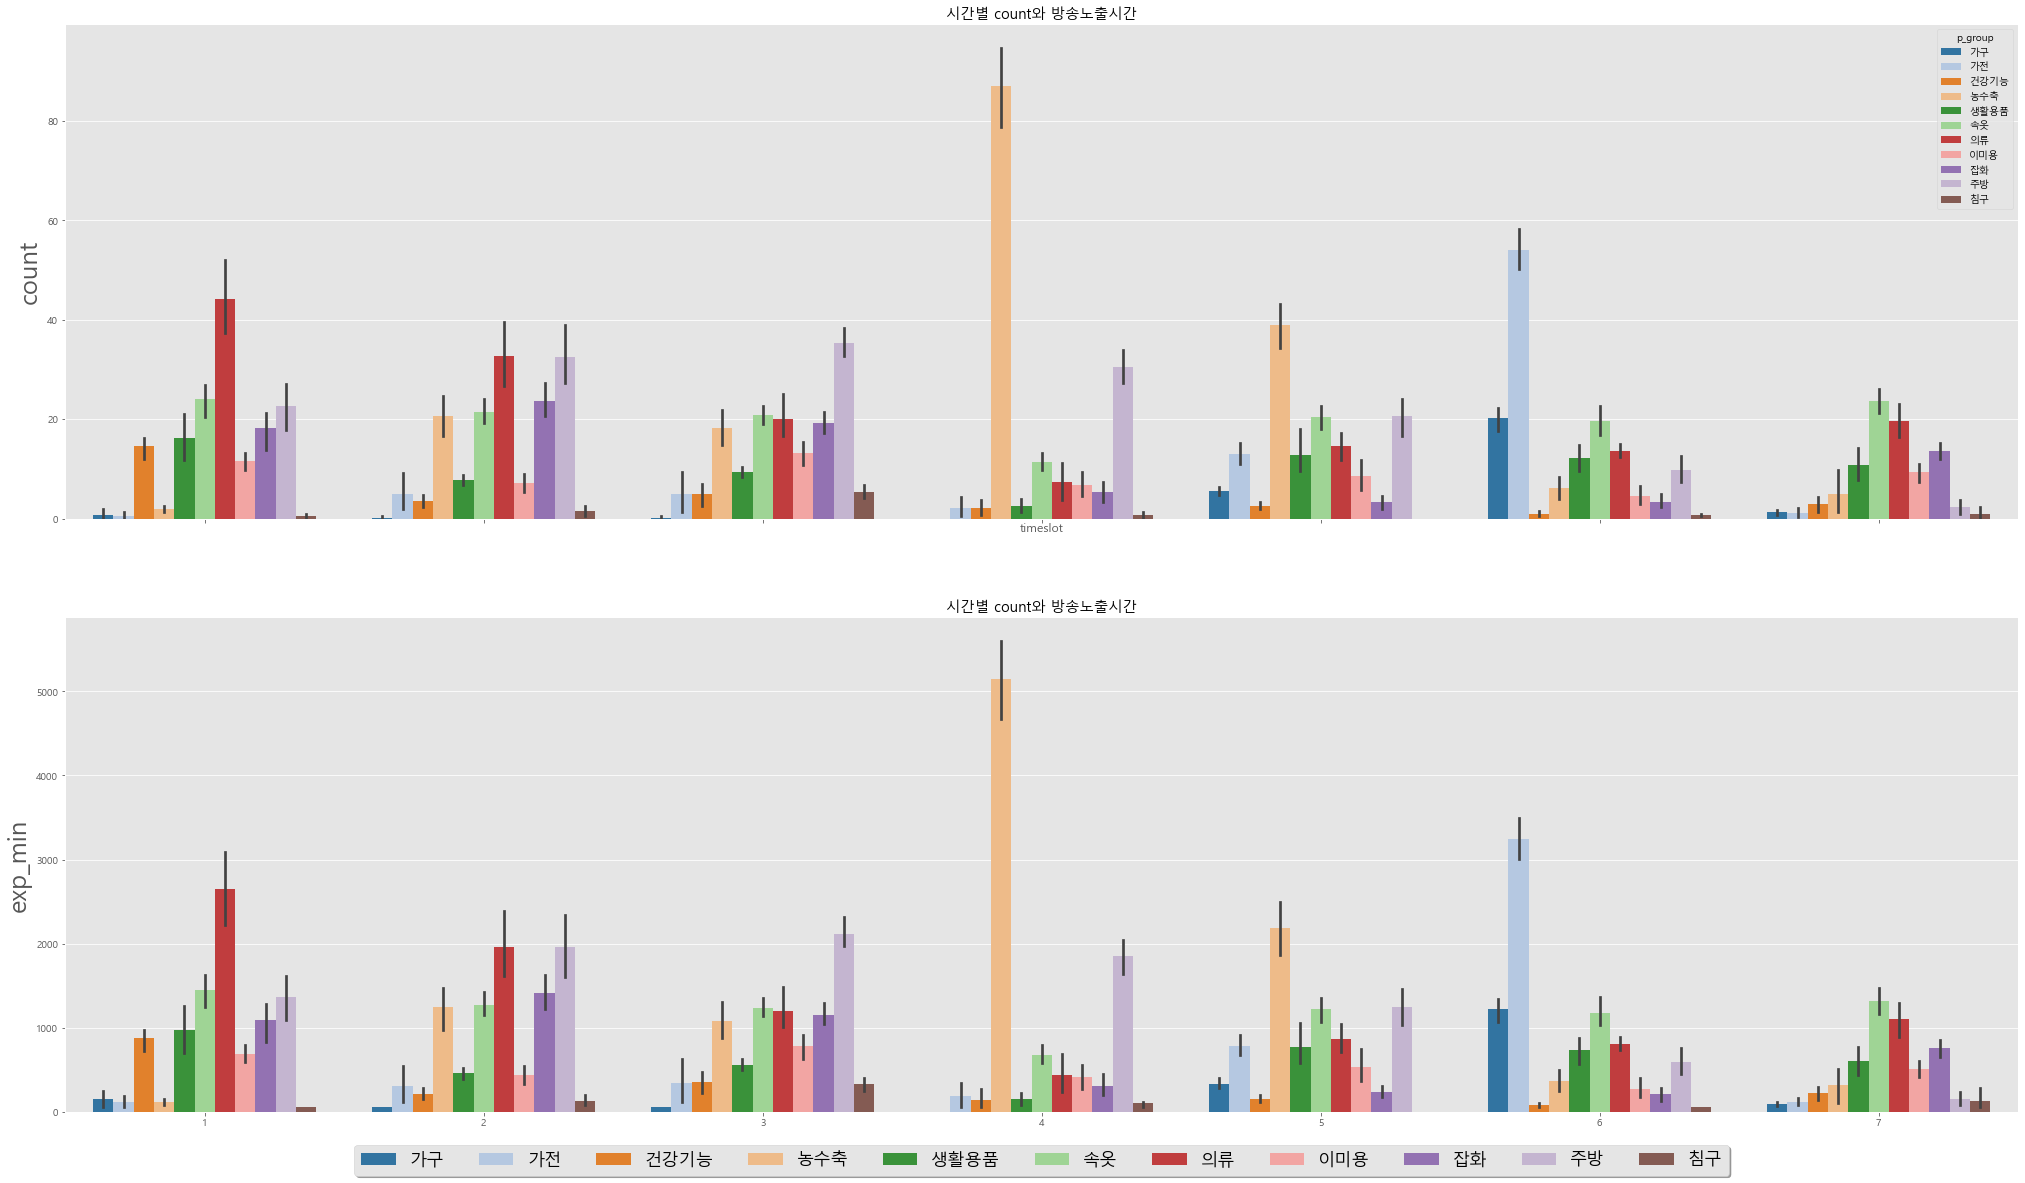

In [69]:
# timesolot별 방송count & 노출시간 합계
wd_ts_cnt = sum_df.groupby(['DAY_NUM','timeslot','p_group']).agg({'unit_price':['count'], 'exp_min':['sum']})
wd_ts_cnt.columns=['count', 'exp_min']
wd_ts_cnt= wd_ts_cnt.reset_index()

fig, axes = plt.subplots(2, 1, figsize=(35, 20), sharex=True)
for name, ax in zip(['count','exp_min'], axes):
    sns.barplot(data=wd_ts_cnt, x='timeslot', y=name, hue='p_group',palette='tab20', ax=ax)
    ax.set_ylabel(name, fontsize=25)
    ax.set_title('시간별 count와 방송노출시간')

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=11, fancybox = True, shadow= True, fontsize= 'xx-large')
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-2]:
    ax.set_xlabel('')

In [77]:
# 요일 -> timeslot -> 상품군
wd_ts_cnt = sum_df.groupby(['DAY_NUM','timeslot','p_group']).agg({'unit_price':['count'], 'exp_min':['sum']})
wd_ts_cnt.columns=['count', 'exp_min']
wd_ts_cnt =wd_ts_cnt.reset_index()

wd_ts_cnt

,DAY_NUM,timeslot,p_group,count,exp_min
0,1,1,가구,0,NaN
1,1,1,가전,0,NaN
2,1,1,건강기능,16,935.016667
3,1,1,농수축,1,60.000000
4,1,1,생활용품,10,600.000000
...,...,...,...,...,...
534,7,7,의류,17,950.550000
535,7,7,이미용,12,562.616667
536,7,7,잡화,13,687.183333
537,7,7,주방,1,60.000000


In [315]:
sum_df.groupby(['MONTH']).agg({'sales':['sum'],'total_price':['sum']})

,sales,total_price
,sum,sum
MONTH,,
1,944761.0,6.884312e+10
2,749984.0,5.960813e+10
3,817390.0,6.461382e+10
4,760537.0,6.073281e+10
5,868922.0,6.883314e+10
6,876670.0,6.645823e+10
7,955577.0,6.896782e+10
8,1064994.0,6.899296e+10


In [366]:
sum_df.p_group.unique()

array(['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구',
       '침구'], dtype=object)